# Objective


The objective is to predict the occurrence of car failure using the provided dataset for an automotive company to formulate mitigative policies.

Since the objective is to predict the occurrence of car failure, and not the types of car failure, this is a binary classification problem.


# 1.0 Importing Packages


In [416]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter        

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2.0 Connecting to Database


## 2.1 Create a connection to SQLite database


In [417]:
con = sqlite3.connect("./src/data/failure.db")

## 2.2 Select all rows from the failure table and display first five rows of data


### 2.2.1 Select all rows from the failure table


In [418]:
df = pd.read_sql_query("SELECT * from failure", con)

### 2.2.2 Displaying first five rows of data


In [419]:
df.head()

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0


# 3.0 Exploratory Data Analysis

Once we have read our dataset, we want to perform some basic data exploration to get a glimpse of our dataset.


## 3.1 Data Summary

We will first begin with getting a summary of the data, such as the dataset dimension, number of non-null values for each variable and the data types.


In [420]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  object 
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        9697 non-null   object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


**Based on the above, we observed the following:**

1. The "Membership" variable contained only 9,697 non-null values while the other variables contain 10,081 non-null variables. This tells us that there are missing values within the dataset.

**We will confirm this observation with the following:**


In [421]:
df.isnull().sum()

Car ID                0
Model                 0
Color                 0
Temperature           0
RPM                   0
Factory               0
Usage                 0
Fuel consumption      0
Membership          384
Failure A             0
Failure B             0
Failure C             0
Failure D             0
Failure E             0
dtype: int64

Based on the above, we observed that there are 384 rows with missing 'Membership' values. While we understand that car owners are automatically subscribed with "Normal" membership for the first five years after car purchase, it could be possible to assume that after five years, car owners could have no memberships. However, if we take reference to the car models of these car owners with missing "Membership" value below...


In [422]:
df[df["Membership"].isnull()]["Model"].value_counts()

Model 3, 2018    56
Model 3, 2020    52
Model 3, 2019    49
Model 3, 2021    48
Model 3, 2022    37
Model 5, 2018    26
Model 5, 2022    21
Model 5, 2020    21
Model 5, 2019    19
Model 5, 2021    13
Model 7, 2021    13
Model 7, 2019    10
Model 7, 2020     7
Model 7, 2018     7
Model 7, 2022     5
Name: Model, dtype: int64

... we observe that the lastest car models are made in 2022 while the earliest car models were made in 2018. Assuming that the data is taken as at 2022, these car owners should have been accorded at least a "Normal" membership since it has not been 5 years after the cars were purchased.

Moreover, since we are unable to determine if these 383 car owners have been automatically subscribed with the "Normal" membership or if they have chosen to upgrade to the "Premium" membership, **we will choose to remove these 383 rows with missing "Membership" values, to allow our model to be more reliable and robust in predicting the occurrence of car failure.**


## 3.2 Removing rows with missing values

We will remove rows with missing "Membership" values by running the following:


In [423]:
df = df.dropna()

In [424]:
df.count()

Car ID              9697
Model               9697
Color               9697
Temperature         9697
RPM                 9697
Factory             9697
Usage               9697
Fuel consumption    9697
Membership          9697
Failure A           9697
Failure B           9697
Failure C           9697
Failure D           9697
Failure E           9697
dtype: int64

In [425]:
print("number of rows after removing rows with missing values: ", df.shape[0])

number of rows after removing rows with missing values:  9697


## 3.3 Check for duplicated rows and remove them

Next, we will check for duplicated rows within the data and remove them to prevent any overfitting from occurring during our model training phase later on


### 3.3.1 Check for duplicated rows


In [426]:
duplicate_rows_df = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows_df.shape[0])

Number of duplicate rows:  80


### 3.3.2 Removing duplicated rows


In [427]:
df = df.drop_duplicates()
df.head(5)

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0


In [428]:
print("number of rows after removing duplicates: ", df.shape[0])

number of rows after removing duplicates:  9617


## 3.4 Checking data types

Next, we'll dive deeper into understanding the data based on their data type.


In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9617 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            9617 non-null   object 
 1   Model             9617 non-null   object 
 2   Color             9617 non-null   object 
 3   Temperature       9617 non-null   object 
 4   RPM               9617 non-null   int64  
 5   Factory           9617 non-null   object 
 6   Usage             9617 non-null   object 
 7   Fuel consumption  9617 non-null   float64
 8   Membership        9617 non-null   object 
 9   Failure A         9617 non-null   int64  
 10  Failure B         9617 non-null   int64  
 11  Failure C         9617 non-null   int64  
 12  Failure D         9617 non-null   int64  
 13  Failure E         9617 non-null   int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


In total, there are currently 7 categorical variables (including the unique identifier 'Car ID'), 6 discrete numeric variables and 1 continuous numeric variable.

We will look into each variable to determine if they require further data pre-processing, starting with the categorical variables.


## 3.5 Analysing categorical variables

In this section, we will perform further analysis on six categorical variables:

1. "Model";
2. "Color";
3. "Temperature";
4. "Factory";
5. "Usage"; and
6. "Membership"


### 3.5.1 Analysing "Model" variable


In [430]:
df["Model"].value_counts()

Model 3, 2016    586
Model 3, 2012    556
Model 3, 2014    552
Model 3, 2013    528
Model 3, 2015    526
Model 3, 2021    512
Model 3, 2020    510
Model 3, 2017    509
Model 3, 2018    485
Model 3, 2019    483
Model 5, 2014    289
Model 5, 2018    289
Model 5, 2016    288
Model 5, 2020    285
Model 3, 2022    278
Model 5, 2012    274
Model 5, 2017    267
Model 5, 2013    263
Model 5, 2015    247
Model 5, 2021    232
Model 5, 2019    225
Model 3, 2011    201
Model 5, 2022    149
Model 7, 2014    103
Model 7, 2016     97
Model 7, 2015     90
Model 7, 2017     88
Model 7, 2018     88
Model 7, 2020     87
Model 7, 2012     86
Model 7, 2013     84
Model 5, 2011     82
Model 7, 2019     80
Model 7, 2021     71
Model 7, 2022     55
Model 3, 2010     31
Model 7, 2011     27
Model 5, 2010      7
Model 7, 2010      5
Model 3, 2009      1
Model 5, 2009      1
Name: Model, dtype: int64

Based on the above, we noticed that the "Model" variable contains information on both the model number and what is assumed to be the year it was manufactured. **Therefore, it is possible to split this information into separate variables for our analysis later on.**


**_Separating "Model" variable into 2 separate variables - "Model" and "Year"_**

The "Model" variable refers to the model of the car, while the "Year" variable refers to the year when the car was manufactured.


In [431]:
df[['Model','Year']] = df.Model.str.split(",", expand=True)

In [432]:
df.head(1)

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,2022


**_Rearranging the columns to place "Model" next to "Year" for easy reference_**


<u>Old column positions</u>


In [433]:
cols = df.columns.tolist()
cols

['Car ID',
 'Model',
 'Color',
 'Temperature',
 'RPM',
 'Factory',
 'Usage',
 'Fuel consumption',
 'Membership',
 'Failure A',
 'Failure B',
 'Failure C',
 'Failure D',
 'Failure E',
 'Year']

<u>New column positions</u>


In [434]:
cols = cols[:2] + cols[-1:] + cols[2:-1]
cols

['Car ID',
 'Model',
 'Year',
 'Color',
 'Temperature',
 'RPM',
 'Factory',
 'Usage',
 'Fuel consumption',
 'Membership',
 'Failure A',
 'Failure B',
 'Failure C',
 'Failure D',
 'Failure E']

In [435]:
df = df[cols]
df.head(1)

,Car ID,Model,Year,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0


**_Visualising "Model" variable_**


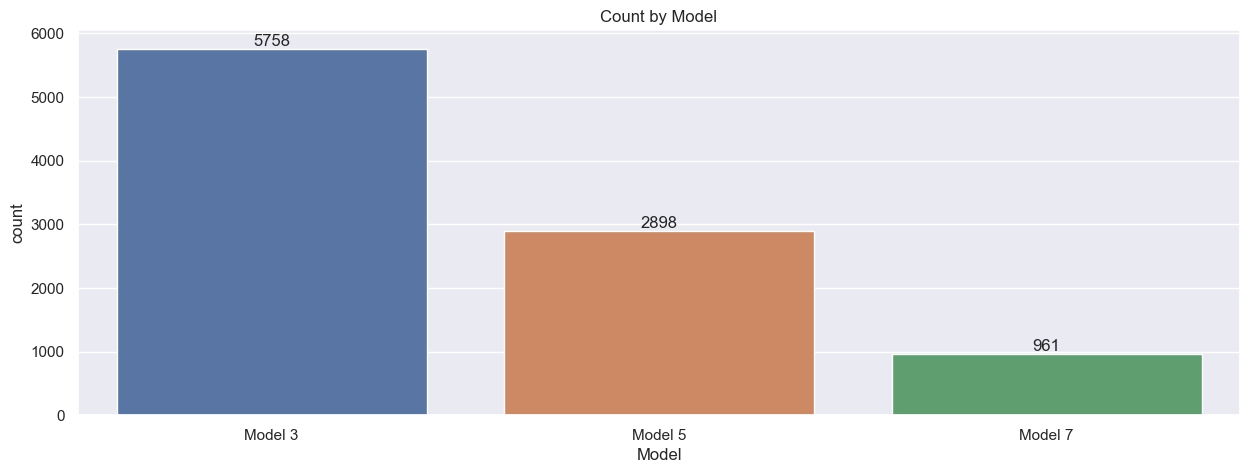

In [436]:
sns.set(style='darkgrid')

figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x=df["Model"], order=df['Model'].value_counts().index)
abs_values = df['Model'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Count by Model')
plt.show()

From the above, we observe that most owners own a Model 3, with 5,758 owners, while Model 7 has the least number of owners, with 961 owners.


**_Visualising "Year" variable_**


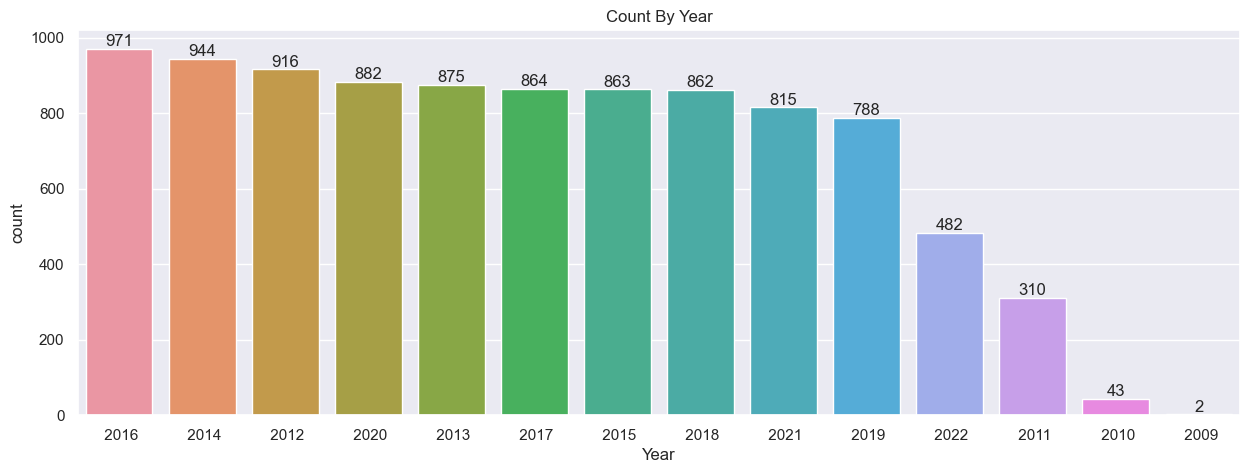

In [437]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x=df["Year"], order=df['Year'].value_counts().index)
abs_values = df['Year'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Count By Year')
plt.show()

From the above, we observe that most of the cars within the data were made in 2016, while the least of them were made in 2009.


### 3.5.2 Analysing "Color" variable


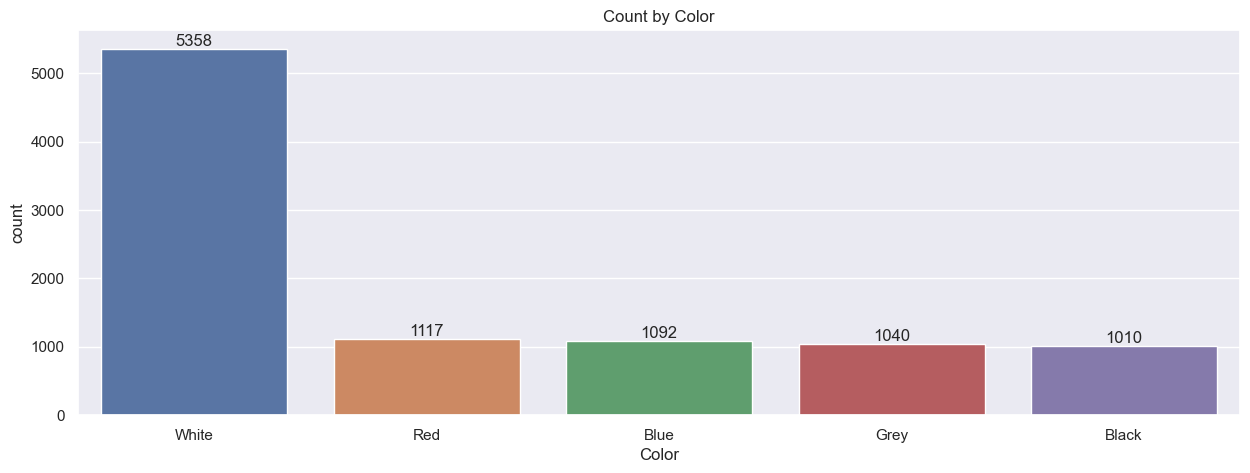

In [438]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x=df["Color"], order=df['Color'].value_counts().index)
abs_values = df['Color'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Count by Color')
plt.show()

Based on the above, nothing out of the ordinary can be identified just by observing each unique value of the "Color" variable.

However, since the objective is to predict the occurrence of car failure, "Color", being a variable that only affects the aesthetic of the vehicle without impact on the internal performance of the vehicle, it would not be useful to include this variable for further analysis in predicting occurrence of car failure.

Therefore, we will proceed to drop this variable from the data.


**_Dropping the "Color" variable from the data_**


In [439]:
df = df.drop('Color', axis=1)
df.head(1)

,Car ID,Model,Year,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0


### 3.5.3 Analysing "Temperature" variable


In [440]:
np.sort(df["Temperature"].unique())

array(['110.0 °C', '110.1 °C', '110.2 °C', '110.3 °C', '110.4 °C',
       '110.5 °C', '110.6 °C', '110.7 °C', '110.8 °C', '110.9 °C',
       '111.0 °C', '111.1 °C', '111.2 °C', '111.3 °C', '111.4 °C',
       '111.5 °C', '111.6 °C', '111.7 °C', '111.8 °C', '111.9 °C',
       '112.1 °C', '112.2 °C', '112.4 °C', '112.5 °C', '112.7 °C',
       '112.9 °C', '113.1 °C', '113.3 °C', '113.6 °C', '113.8 °C',
       '114.1 °C', '114.4 °C', '114.7 °C', '115.1 °C', '115.4 °C',
       '115.8 °C', '116.2 °C', '116.7 °C', '117.2 °C', '117.7 °C',
       '118.2 °C', '118.8 °C', '119.5 °C', '120.1 °C', '120.9 °C',
       '121.6 °C', '122.5 °C', '123.4 °C', '124.3 °C', '125.4 °C',
       '126.5 °C', '127.7 °C', '128.9 °C', '130.3 °C', '131.7 °C',
       '133.3 °C', '135.0 °C', '136.8 °C', '138.7 °C', '230.1 °F',
       '230.2 °F', '230.3 °F', '230.4 °F', '230.5 °F', '230.6 °F',
       '230.7 °C', '230.7 °F', '230.8 °F', '230.9 °F', '231.0 °F',
       '231.1 °F', '231.2 °F', '231.3 °F', '231.4 °F', '231.5 

Even though temperature should be a continuous numeric variable, it is currently defined as a categorical variable as it also contains information on whether the temperature is in fahrenheit or celsius.

Therefore, we will first split this information into two separate variables before conducting further analysis - one containing the temperature value, and one containing the temperature unit.


In [441]:
df[['Temperature','Temperature Scale']] = df.Temperature.str.split(expand=True)
df.head(1)

,Car ID,Model,Year,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Temperature Scale
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,110.3,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,°C


**_Changing the data type of "Temperature" to continuous numeric_**


In [442]:
df["Temperature"] = df["Temperature"].astype("float64")

In [443]:
df[["Temperature", "Temperature Scale"]].dtypes

Temperature          float64
Temperature Scale     object
dtype: object

**_Rearranging the columns to place "Temperature" next to "Temperature Scale" for easy reference_**


<u>Old column positions</u>


In [444]:
cols = df.columns.tolist()
cols

['Car ID',
 'Model',
 'Year',
 'Temperature',
 'RPM',
 'Factory',
 'Usage',
 'Fuel consumption',
 'Membership',
 'Failure A',
 'Failure B',
 'Failure C',
 'Failure D',
 'Failure E',
 'Temperature Scale']

<u>New column positions</u>


In [445]:
cols = cols[:4] + cols[-1:] + cols[4:-1]
cols

['Car ID',
 'Model',
 'Year',
 'Temperature',
 'Temperature Scale',
 'RPM',
 'Factory',
 'Usage',
 'Fuel consumption',
 'Membership',
 'Failure A',
 'Failure B',
 'Failure C',
 'Failure D',
 'Failure E']

In [446]:
df = df[cols]
df.head(1)

,Car ID,Model,Year,Temperature,Temperature Scale,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,110.3,°C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0


**_Evaluating temperature values in Celsius_**


Next, we want to take a look at the values of the temperature in Celsius and Fahrenheit individually to determine if they require further cleaning.

We will start by taking a look at the temperature in Celsius.


In [447]:
df[df["Temperature Scale"]=="°C"]["Temperature"].describe()

count    7527.000000
mean      113.091178
std         4.695390
min       110.000000
25%       110.400000
50%       111.400000
75%       113.600000
max       230.700000
Name: Temperature, dtype: float64

The mean temperature in Celsius was approximately 113.1°C while the highest temperature recorded was 230.7°C. This could indicate that there is presence of outlier(s).


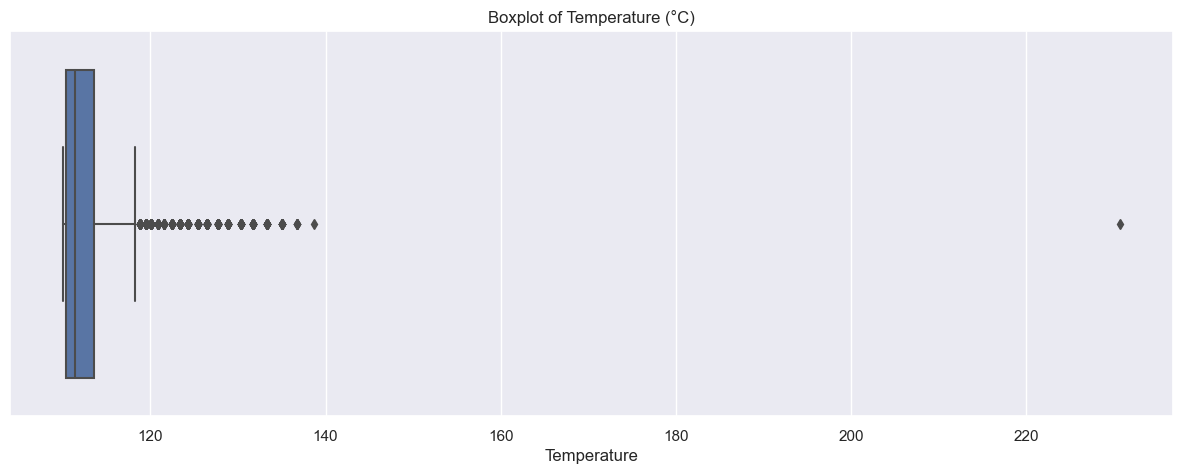

In [448]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x=df[df["Temperature Scale"]=="°C"]["Temperature"]).set_title('Boxplot of Temperature (°C)')
plt.show()

According to external resources, an article from http://www.agcoauto.com/content/news/p2_articleid/227 indicated that "As temperature of an engine exceeds 230 degrees Fahrenheit (110 degrees Celsius), the engine is overheated. Above 245 degrees Fahrenheit (118 degrees Celsius), damage may occur. As heat continues to increase, the different rates of thermal expansion cause metal to distort."

Since the "Temperature" variable refers to the average 30 days temperature of the car engine before failure detected, the outlier temperature of 230.7°C is oddly high. It could be possible that it was wrongly inputted as Celsius when it should have been on the Fahrenheit scale.

Additionally, with reference to the below...


In [449]:
df[df["Temperature"]==230.7]

,Car ID,Model,Year,Temperature,Temperature Scale,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,2022,230.7,°C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0
178,88bd240e-4ad3-49e1-aae9-9da07580079c,Model 3,2020,230.7,°F,1436,"New York, U.S",Low,622.3,Normal,0,0,0,0,0
184,1928b721-204f-4aea-84a4-75e3550632f4,Model 3,2019,230.7,°F,1667,"New York, U.S",Low,652.4,Normal,0,0,0,0,0
187,bde67166-708a-4879-9922-cc57012e0b3d,Model 3,2019,230.7,°F,1379,"New York, U.S",High,690.5,Premium,0,0,0,0,0
201,3ea04f69-7119-4a78-8a5c-5bffc7010967,Model 3,2017,230.7,°F,1575,"New York, U.S",High,680.9,None,0,0,0,0,0
216,4c49b785-f394-4d4f-a946-658148fa0970,Model 3,2015,230.7,°F,1499,"New York, U.S",High,659.5,Premium,0,1,0,0,0
218,eeefcaff-275a-4a96-96b2-05c56ecae584,Model 3,2015,230.7,°F,1447,"New York, U.S",Low,620.7,None,0,0,0,0,0
227,52981549-6217-46ee-8d5b-0da73d8ce226,Model 3,2014,230.7,°F,1539,"New York, U.S",Medium,633.3,Normal,0,0,0,0,0
228,a9560360-a847-446f-99a4-95230854dc42,Model 5,2014,230.7,°F,1629,"New York, U.S",High,680.7,Premium,0,0,0,0,0
620,fa7794db-3581-44bd-bc71-7a2fa7fdc2dc,Model 5,2018,230.7,°F,1389,"New York, U.S",Low,660.1,Premium,0,0,0,0,0


... We noticed that there are other occurrences of cars with recorded temperature of 230.7, but in Fahrenheit. Moreover, these cars were manufactured in New York, U.S, which uses the Fahrenheit scale, just like the outlying data point.

**Therefore, we will replace the outlying "Temperature Scale" with °F instead of °C.**


**_Replacing "Temperature Scale" of index 4 of the data with °F instead of °C_**


In [450]:
df.iloc[4,:] = df.iloc[4,:].replace("°C", "°F")

**_Re-visualising "Temperature" variable on the Celsius scale_**


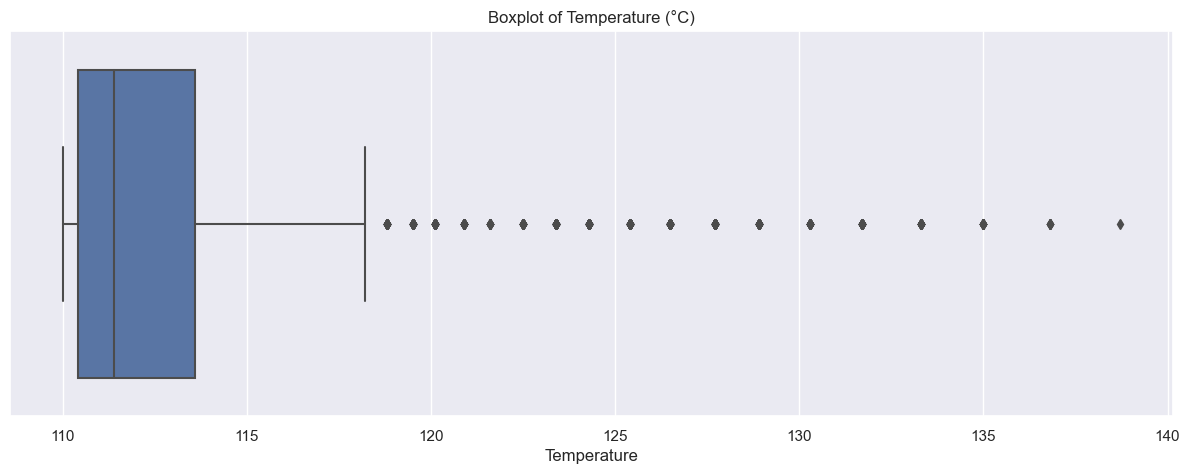

In [451]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x=df[df["Temperature Scale"]=="°C"]["Temperature"]).set_title('Boxplot of Temperature (°C)')
plt.show()

Based on the above, we can see that there are still several points of outliers for the "Temperature" variable on the Celsius scale. However, given that the "Temperature" variable is an average of 30 days temperature of the car engine before failure detected, the outliers could still be legitimate anomalies, where there is an occurrence of a single day of high temperature right before car failure.

Therefore, we will not be dropping these outliers for now.


**_Evaluating temperature values in Fahrenheit_**


In [452]:
df[df["Temperature Scale"]=="°F"]["Temperature"].describe()

count    2091.000000
mean      235.594357
std         8.173426
min       230.100000
25%       230.800000
50%       232.400000
75%       236.500000
max       278.200000
Name: Temperature, dtype: float64

The mean temperature in Fahrenheit was approximately 235.6°F (approximately 113.1°C) while the highest temperature recorded was 278.2°F (approximately 136.8°C). This could indicate that there is presence of outlier(s).


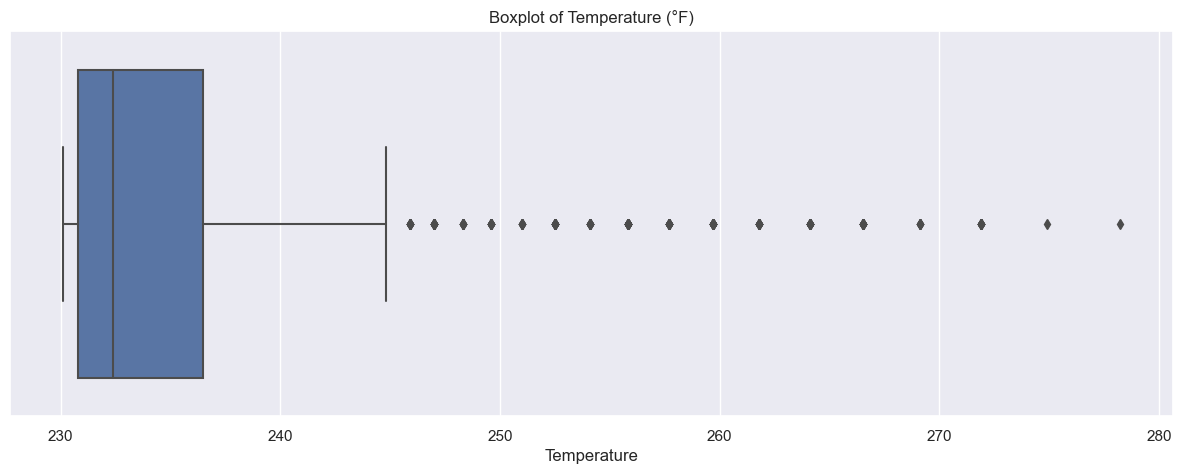

In [453]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x=df[df["Temperature Scale"]=="°F"]["Temperature"]).set_title('Boxplot of Temperature (°F)')
plt.show()

Based on the above, we can see that there are still several points of outliers for the "Temperature" variable on the Fahrenheit scale. However, given that the "Temperature" variable is an average of 30 days temperature of the car engine before failure detected, the outliers could still be legitimate anomalies, where there is an occurrence of a single day of high temperature right before car failure.

Therefore, we will not be dropping these outliers for now.


**_Converting all temperature values in Fahrenheit scale into Celsius scale_**

To facilitate our data modelling in later stage, we will be converting all temperatures to be in the same scale. In this case, we will be converting them into the Celsius scale.


In [454]:
df.loc[df["Temperature Scale"]=="°F", 'Temperature'] = (df[df["Temperature Scale"]=="°F"]["Temperature"] - 32) * 5/9

In [455]:
df["Temperature Scale"] = "°C"

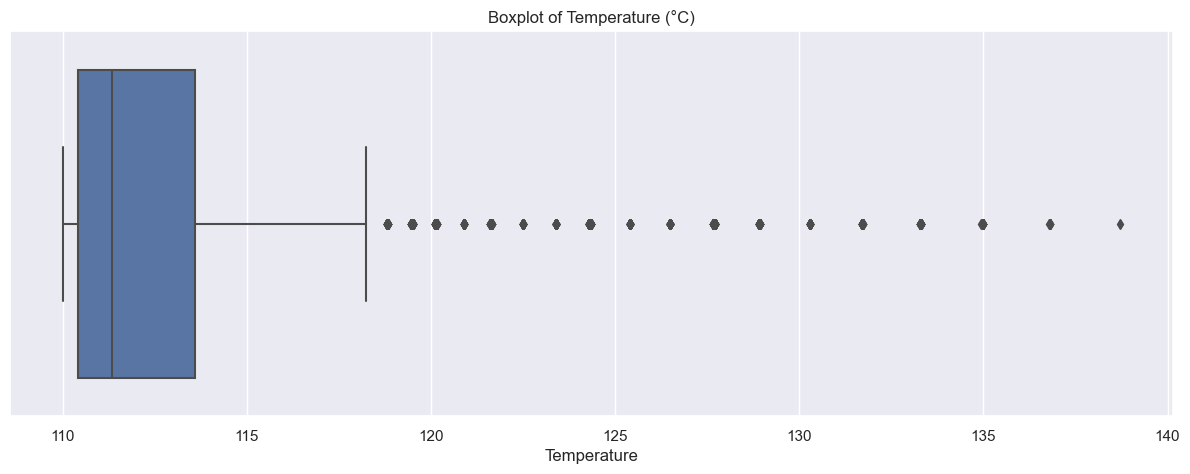

In [456]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x=df["Temperature"]).set_title('Boxplot of Temperature (°C)')
plt.show()

In [457]:
df["Temperature"].describe()

count    9617.000000
mean      113.082601
std         4.505320
min       110.000000
25%       110.400000
50%       111.333333
75%       113.600000
max       138.700000
Name: Temperature, dtype: float64

Upon converting all temperature values to Celsius, the max value is approximately 138.7°C while the mean is approximately 113.1°C.


**_Removing "Temperature Scale" variable since all Temperature values are now on the Celsius scale_**


In [458]:
df = df.drop(['Temperature Scale'], axis=1)

In [459]:
df.head(1)

,Car ID,Model,Year,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,110.3,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0


### 3.5.4 Analysing "Factory" variable


In [460]:
np.sort(df["Factory"].unique())

array(['Bedok, Germany', 'Berlin, Germany', 'New York, U.S',
       'Newton, China', 'Seng Kang, China', 'Shang Hai, China'],
      dtype=object)

Based on the above, we observe that there are some anomalous values. "Bedok, Germany", "Newton, China" and "Seng Kang, China" do not appear to be the right values as "Bedok", "Newton" and "Seng Kang" are regions within Singapore.


In [461]:
np.sort(df[df["Factory"]=="Bedok, Germany"]["Year"].unique())

array([' 2011', ' 2013', ' 2014', ' 2015', ' 2016', ' 2017', ' 2018',
       ' 2019', ' 2021', ' 2022'], dtype=object)

In [462]:
np.sort(df[df["Factory"]=="Newton, China"]["Year"].unique())

array([' 2011', ' 2012', ' 2013', ' 2014', ' 2015', ' 2016', ' 2017',
       ' 2018', ' 2019'], dtype=object)

In [463]:
np.sort(df[df["Factory"]=="Seng Kang, China"]["Year"].unique())

array([' 2011', ' 2012', ' 2013', ' 2014', ' 2015', ' 2016', ' 2017',
       ' 2019', ' 2020', ' 2021'], dtype=object)

Additionally, based on the information of the year of car manufactured above, with 2011 being the earliest, Singapore could not have manufactured these cars as Singapore does not have any car manufacturing facilities then\*.

\*_Source - https://www.fuelsandlubes.com/singapore-car-manufacturing-facility-electric/_

Therefore, assuming that only the region was inputted incorrectly, we will continue to consider the country where the cars are manufactured, without taking into account of the region within the country. Therefore, we will not be dropping any data.


**_Removing Regions from the "Factory" variable, leaving only the Country_**


In [464]:
df["Factory"] = df["Factory"].map(lambda x: x.split(", ")[1])

In [465]:
df["Factory"].unique()

array(['China', 'Germany', 'U.S'], dtype=object)

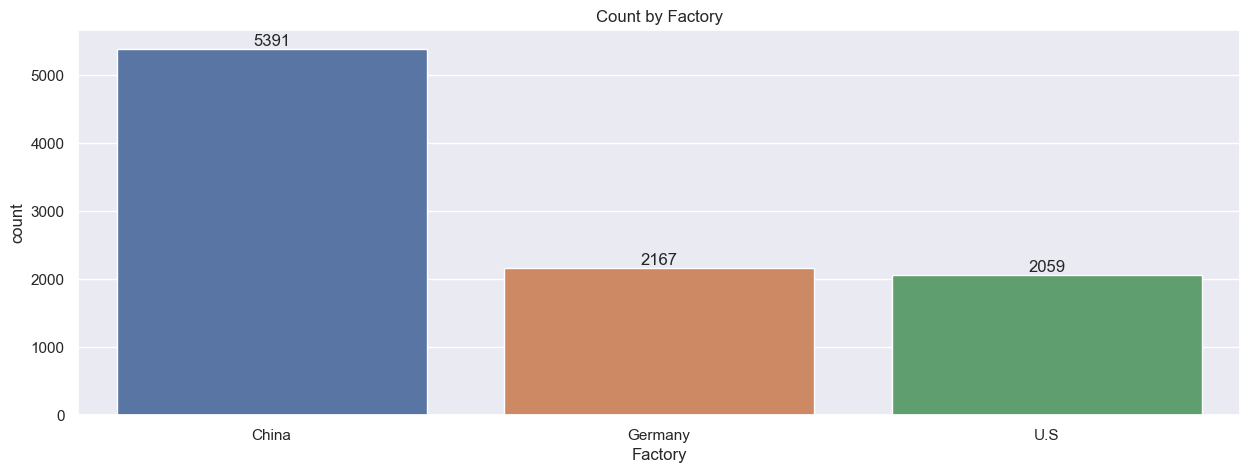

In [466]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x=df["Factory"], order=df['Factory'].value_counts().index)
abs_values = df['Factory'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Count by Factory')
plt.show()

Based on the above, we observe that majority of the cars in the data (5,391 of them) are manufactured in China, while cars in the data that are least manufactured in the U.S (2,059 of them)


### 3.5.5 Analysing "Usage" variable


In [467]:
df["Usage"].unique()

array(['Medium', 'Low', 'High'], dtype=object)

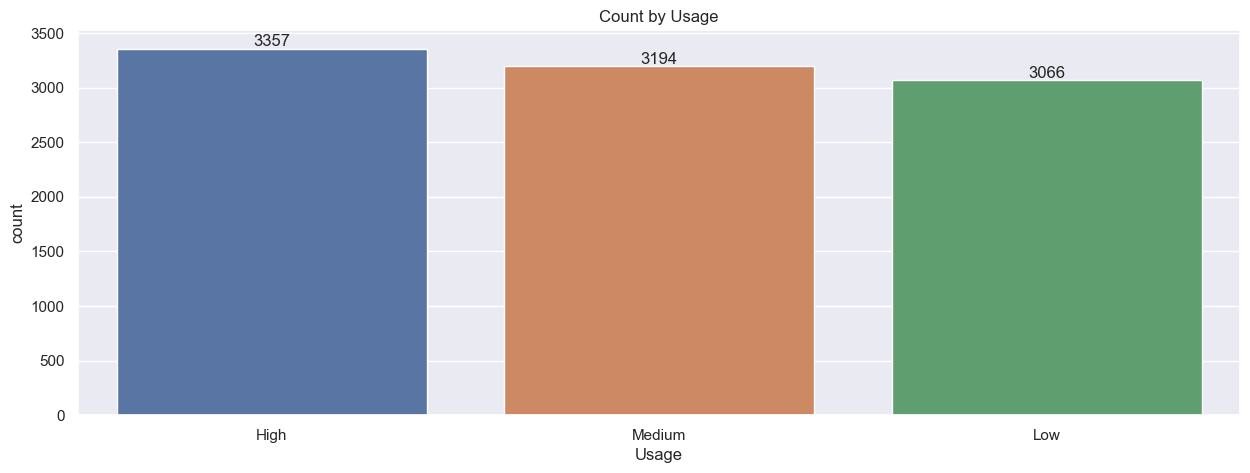

In [468]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x=df["Usage"], order=df['Usage'].value_counts().index)
abs_values = df['Usage'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Count by Usage')
plt.show()

Based on the above, we observe that majority of the cars in the data (3,357 of them) are of "High" usage, while cars of "Low" usage are the least, with 3,066 of them.


### 3.5.6 Analysing "Membership" variable


In [469]:
df["Membership"].unique()

array(['Normal', 'Premium', 'None'], dtype=object)

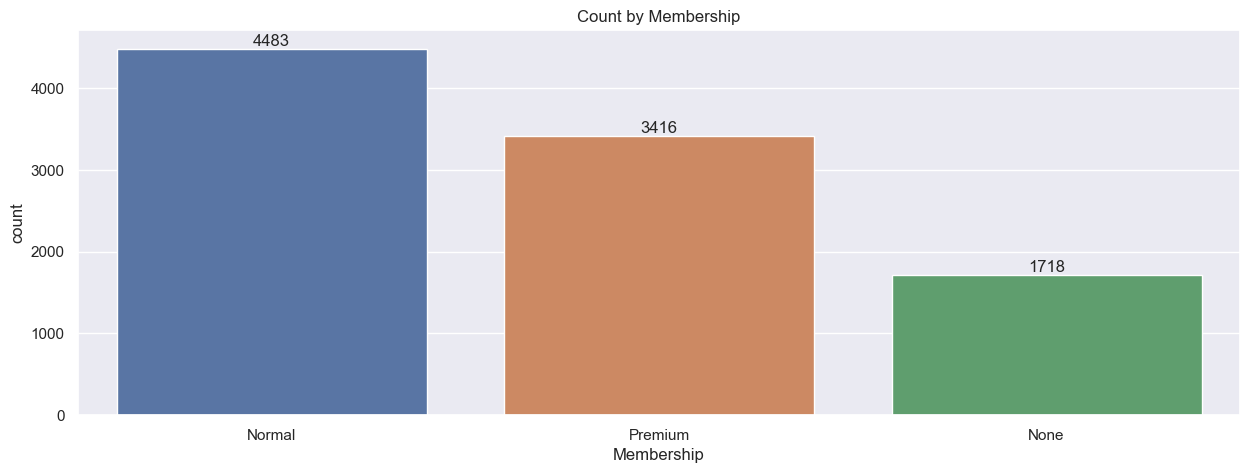

In [470]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x=df["Membership"], order=df['Membership'].value_counts().index)
abs_values = df['Membership'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Count by Membership')
plt.show()

Based on the above, we observe that majority of the cars in the data (4,483 of them) are of "Normal" membership, while cars with "None" memberships are the least, with 1,718 of them.

In this case, we assume that cars with "None" memberships are cars that are older than five years, and the car owners have not renewed their memberships. To confirm this understanding, we will check if these cars are older than five years.


In [471]:
np.sort(df[df["Membership"]=="None"]["Year"].unique())

array([' 2010', ' 2011', ' 2012', ' 2013', ' 2014', ' 2015', ' 2016',
       ' 2017'], dtype=object)

Based on the above, we can see that the lastest year in which the cars are manufactured is 2017, which would mean that the cars are currently older than five years, assuming that the data is taken at 2022.


In [472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9617 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            9617 non-null   object 
 1   Model             9617 non-null   object 
 2   Year              9617 non-null   object 
 3   Temperature       9617 non-null   float64
 4   RPM               9617 non-null   int64  
 5   Factory           9617 non-null   object 
 6   Usage             9617 non-null   object 
 7   Fuel consumption  9617 non-null   float64
 8   Membership        9617 non-null   object 
 9   Failure A         9617 non-null   int64  
 10  Failure B         9617 non-null   int64  
 11  Failure C         9617 non-null   int64  
 12  Failure D         9617 non-null   int64  
 13  Failure E         9617 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 1.1+ MB


## 3.6 Analysing numeric variables

In this section, we will perform further analysis on two numeric variables:

1. "RPM";
2. "Fuel consumption";


### 3.6.1 Analysing "RPM" variable


In [473]:
df["RPM"].describe()

count    9617.000000
mean     1471.089113
std       484.207505
min     -2636.000000
25%      1418.000000
50%      1500.000000
75%      1609.000000
max      2886.000000
Name: RPM, dtype: float64

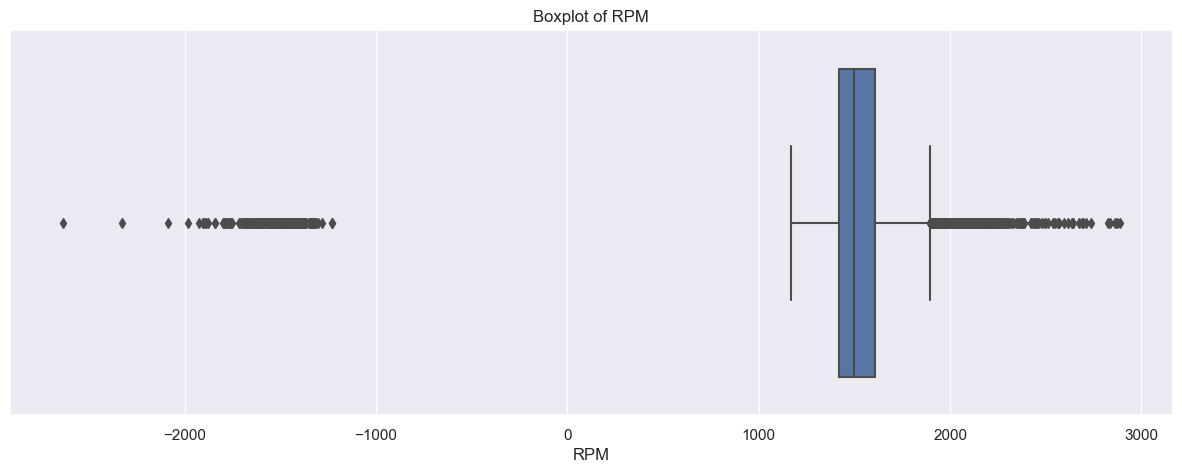

In [474]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x=df["RPM"]).set_title('Boxplot of RPM')
plt.show()

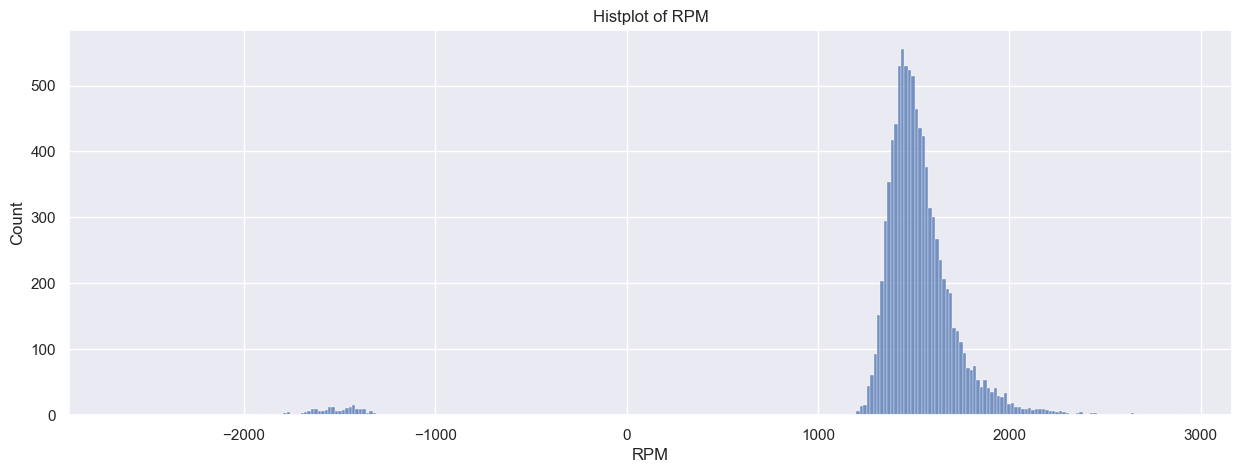

In [475]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(x=df["RPM"]).set_title('Histplot of RPM')
plt.show()

Based on the histogram and boxplot above, we can see that there are instances of RPM recorded in the negative.


In [476]:
print("In total, there are", df[df["RPM"] < 0]["RPM"].count(), "rows with negative RPM.")

In total, there are 211 rows with negative RPM.


While negative RPM seems anomalous, it could potentially describe the rate at which the rotor is revolving in the opposite direction, which may in turn hold a significant relation to the target variables.

In order to test the hypothesis that the direction of revolving rotor is related to the type of car failure, we will implement a Chi-square test of independence of variables in a contingency table.

We start by:

1. Creating a new variable "isPositiveDirection" to indicate whether the rotor was recorded in the positive direction or the negative direction.
2. Thereafter, we define the null hypothesis, which states that there is no relation between the variables, and implement the chi2_contingency function from scipy.stats package.


**_Creating "isPositiveDirection" Variable_**


In [477]:
df["isPositiveDirection"] = np.where(df['RPM'] >= 0, "1", "0")

**_The following is the contingency table:_**


In [478]:
df[["isPositiveDirection", "Failure A", "Failure B", "Failure C", "Failure D", "Failure E"]].groupby("isPositiveDirection").sum()

,Failure A,Failure B,Failure C,Failure D,Failure E
isPositiveDirection,,,,,
0,7,2,1,5,1
1,193,123,205,171,171


**_The following is the implementation of chi2_contingency function from scipy.stats package:_**


In [479]:
# defining the table
data = df[["isPositiveDirection", "Failure A", "Failure B", "Failure C", "Failure D", "Failure E"]].groupby("isPositiveDirection").sum()
stat, p, dof, expected = chi2_contingency(data)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.10124007875486994
Independent (H0 holds true)


Based on the results obtained above, H0 is accepted, that is, the variables do not have a significant relation.

Therefore, since

1. The direction of the rotor movement does not hold significant relation to the types of car failures; and
2. The anomalous data points with negative RPM are outliers;

we will proceed to:

1. Remove the newly created column of "isPositiveDirection" variable; and
2. Remove the data points containing the negative RPM variable from the data.


**_Removing "isPositiveDirection" Variable_**


In [480]:
df = df.drop(['isPositiveDirection'], axis=1)

**_Removing outlying rows with negative RPM_**


In [481]:
df = df[df["RPM"]>=0]

**_Upon dropping "RPM" values that are negative, we will now inspect its distribution._**


In [482]:
df["RPM"].describe()

count    9406.000000
mean     1538.692324
std       175.252007
min      1168.000000
25%      1424.000000
50%      1504.000000
75%      1612.000000
max      2886.000000
Name: RPM, dtype: float64

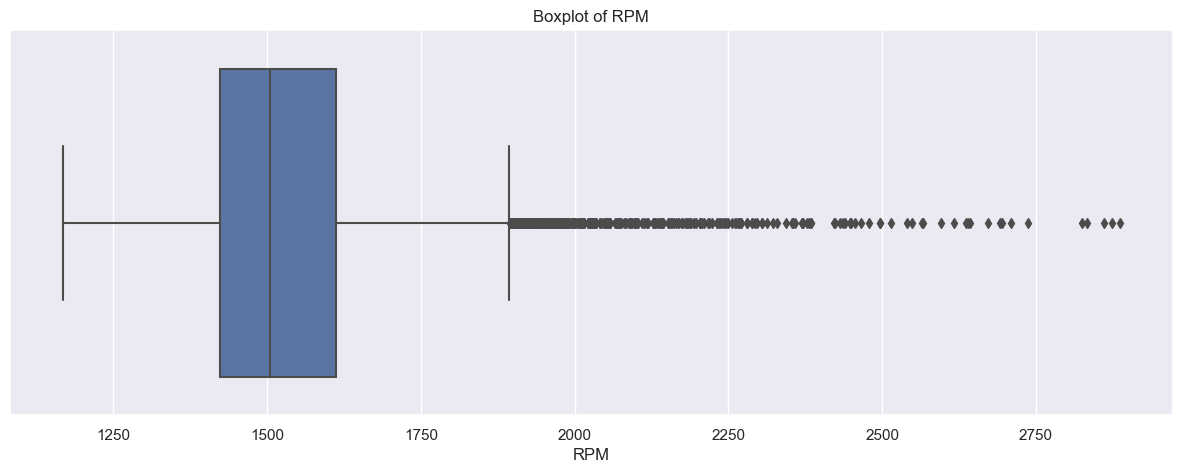

In [483]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x=df["RPM"]).set_title('Boxplot of RPM')
plt.show()

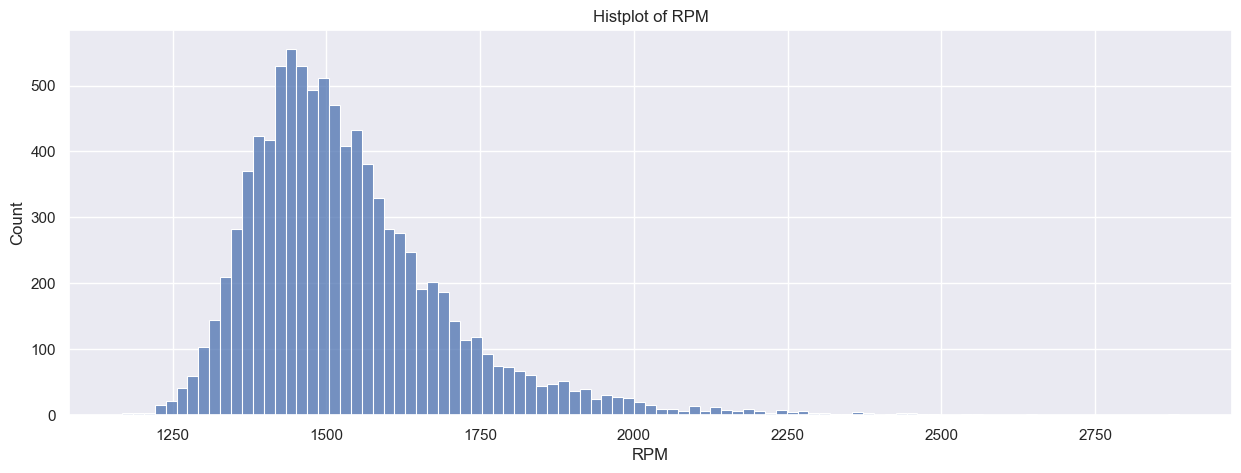

In [484]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(x=df["RPM"]).set_title('Histplot of RPM')
plt.show()

The distribution of the data appears to be less skewed than before, where it was slightly bimodal without the removal of the negative RPM values. However, the data is still slightly skewed to the right. Having a skewed data could potentially degrade the model's ability to describe typical cases as it has to deal with rare cases with extreme values. Although having skewed data does not affect tree-based models, it could still potentially affect other statisticaly models that we might want to employ at the later stage.


In [485]:
df["RPM"].skew()

1.8581566801184246

Currently, the skewness of the data is 1.8581566801184246 as calculated above. We will attempt to apply log transformation to reduce skewness.


**_Applying log transformation to RPM variable_**


In [486]:
df["RPM"] = np.log(df["RPM"])

In [487]:
df["RPM"].skew()

1.2301876383398431

Based on the above, we can see that the skewness of the data has reduced to 1.23 from 1.86.


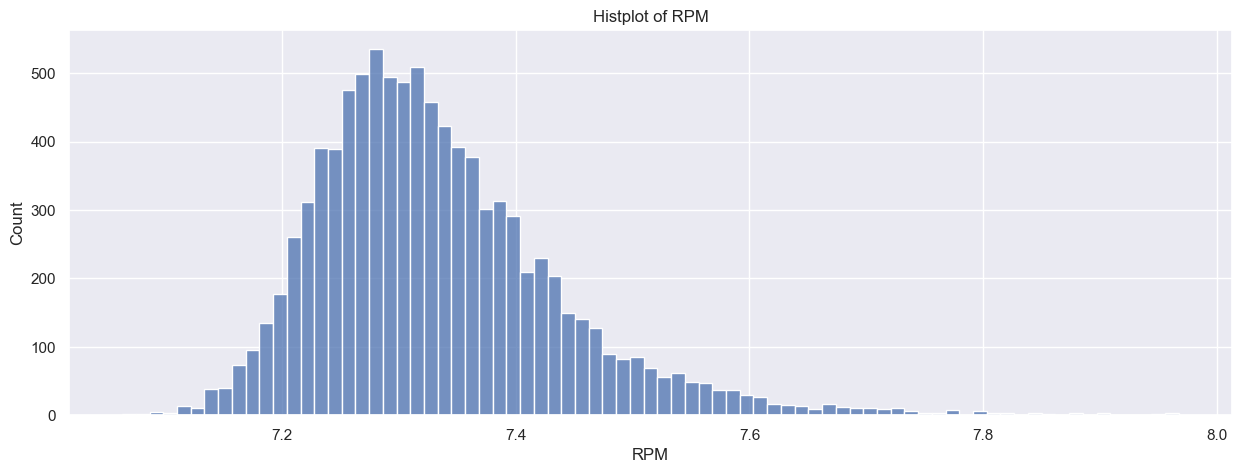

In [488]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(x=df["RPM"]).set_title('Histplot of RPM')
plt.show()

While it is still slightly skewed to the right, the transformed data is now less asymmetrical than before.


### 3.6.2 Analysing "Fuel consumption" variable


In [489]:
df["Fuel consumption"].describe()

count    9406.000000
mean      678.797906
std        58.087537
min       598.500000
25%       638.500000
50%       667.800000
75%       702.800000
max       904.800000
Name: Fuel consumption, dtype: float64

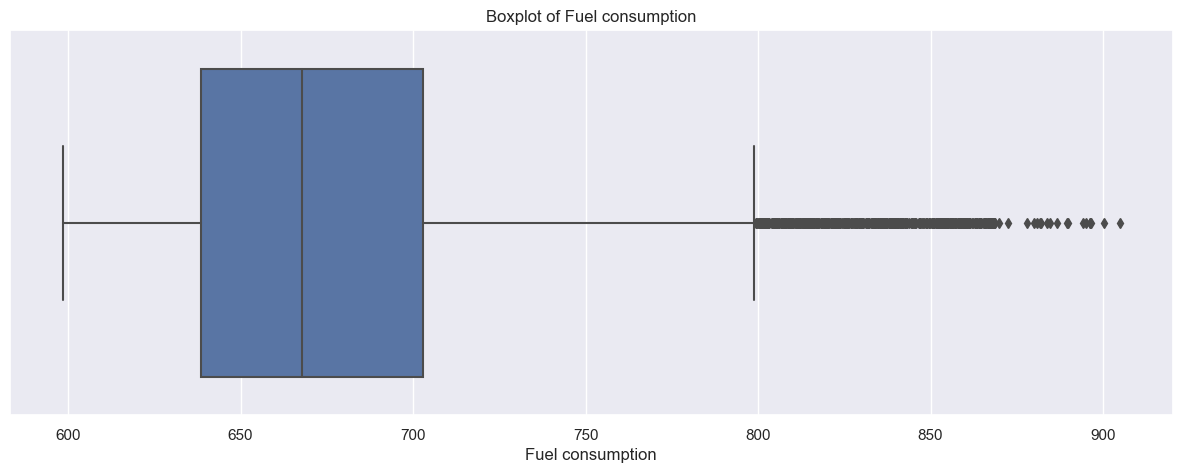

In [490]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x=df["Fuel consumption"]).set_title('Boxplot of Fuel consumption')
plt.show()

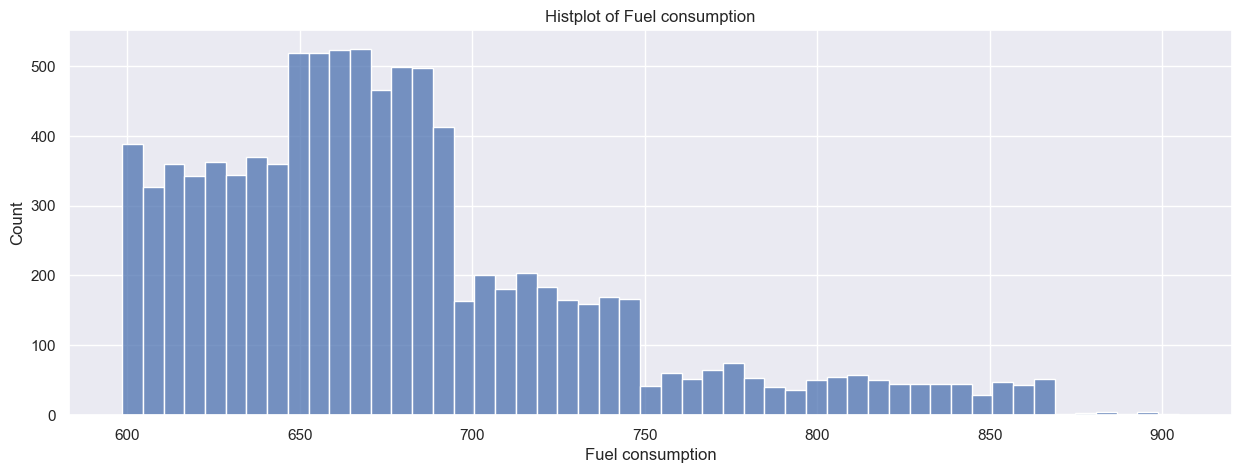

In [491]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(x=df["Fuel consumption"]).set_title('Histplot of Fuel consumption')
plt.show()

In [492]:
df["Fuel consumption"].skew()

1.1880902791592003

The "Fuel consumption" variable appears to be skewed to the right. Additionally, the skewness of the data is 1.1880902791592003 as calculated above. We will attempt to apply log transformation to approximate the data to a normal distribution.


**_Applying log transformation to Fuel consumption variable_**


In [493]:
df["Fuel consumption"] = np.log(df["Fuel consumption"])

In [494]:
df["Fuel consumption"].skew()

0.9618387686410809

Based on the above, we can see that the skewness of the data has reduced to 0.96 from 1.19.


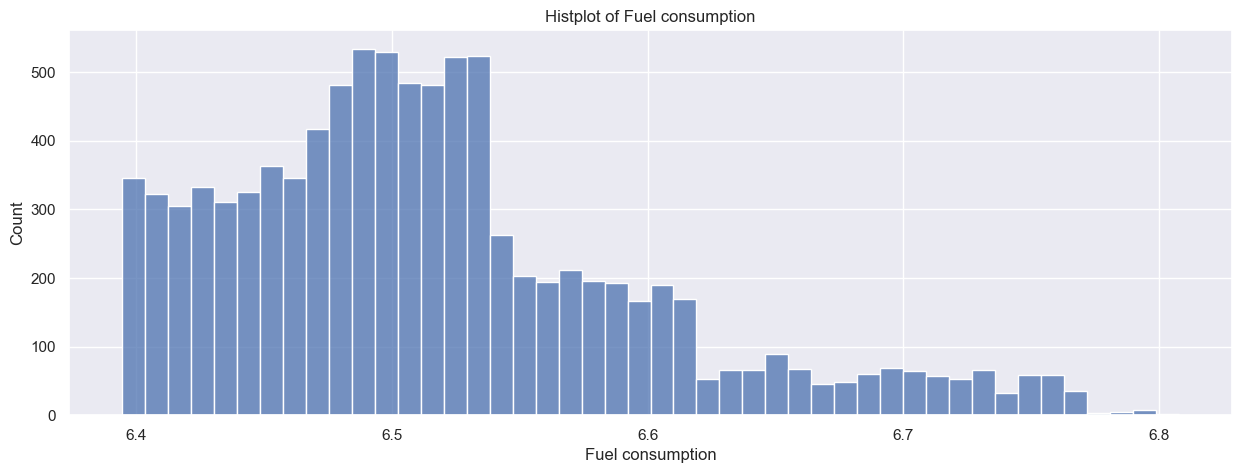

In [495]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(x=df["Fuel consumption"]).set_title('Histplot of Fuel consumption')
plt.show()

While it is still slightly skewed to the right, the transformed data is now less asymmetrical than before.


## 3.7 Target Variable - Combining car failure types into a single target binary variable

As the objective is to predict the occurrence of car failure using the provided dataset for an automotive company to formulate mitigative policies, this is a binary classification problem.

Therefore, we will need to combine all car failure types into a single binary variable "y" to allow for model training later on.

To do this, we will perform a quick analysis of the unique values of each variable to ensure that each car failure type is currently a binary variable.


**_Checking unique values of each variable_**


In [496]:
df["Failure A"].unique()

array([0, 1])

In [497]:
df["Failure B"].unique()

array([0, 1])

In [498]:
df["Failure C"].unique()

array([0, 1])

In [499]:
df["Failure D"].unique()

array([0, 1])

In [500]:
df["Failure E"].unique()

array([0, 1])

From the above, it appears that each target variable are binary, with each data point being either 0 or 1.


**_Given that the objective is to predict the occurrence of a car failure and not the types of car failure, this is a binary classification problem_**

Therefore, for the purpose of training our model later on, we will merge the target variables of "Failure A", "Failure B", "Failure C", "Failure D" and "failure E" into a single target variable called "y", and to assign 1 to samples with occurrence of a car failure, and 0 to samples with no occurrence of a car failure.


In [501]:
def get_y(row):
    for c in df[["Failure A","Failure B","Failure C","Failure D","Failure E"]].columns:
        if row[c]==1:
            return 1

In [502]:
df["y"] = df[["Failure A","Failure B","Failure C","Failure D","Failure E"]].apply(get_y, axis=1)

In [503]:
df["y"] = df["y"].fillna(0)

**_Changing target variable data type to integer_**


In [504]:
df["y"] = df["y"].astype("int64")

In [505]:
df.head()

,Car ID,Model,Year,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,y
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,110.300000,7.346655,China,Medium,6.491785,Normal,0,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,2022,110.400000,7.249926,China,Medium,6.558623,Premium,1,0,0,0,0,1
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,2022,110.300000,7.311886,China,Low,6.508322,Premium,0,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,2022,110.400000,7.267525,Germany,High,6.446672,Premium,1,0,0,0,0,1
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,2022,110.388889,7.249926,U.S,High,6.493603,Normal,0,1,0,0,0,1


## 3.8 Categorical encoding

Since there are five object variables within the data, which are:

1. Model
2. Year
3. Factory
4. Usage
5. Membership

we would want to apply categorical encoding to convert them into numerical data type as many machine learning algorithms are not able to work with categorical data directly.

Therefore, we will be performing integer encoding on categories that have a natural ordinal relationship, such as the "Model", "Year", "Usage" and "Membership"variables.

For the "Factory" variable, which does not have any ordinal relationship, we will be applying one hot encoding directly.


**_Applying integer encoding on "Model" variable_**


In [506]:
np.sort(df["Model"].unique())

array(['Model 3', 'Model 5', 'Model 7'], dtype=object)

In [507]:
model_data = df["Model"]
model_values = np.array(model_data)
model_label_encoder = LabelEncoder()
model_integer_encoded = model_label_encoder.fit_transform(model_values)

In [508]:
df["model_encoded"] = model_integer_encoded

**_Applying integer encoding on "Year" variable_**


In [509]:
np.sort(df["Year"].unique())

array([' 2009', ' 2010', ' 2011', ' 2012', ' 2013', ' 2014', ' 2015',
       ' 2016', ' 2017', ' 2018', ' 2019', ' 2020', ' 2021', ' 2022'],
      dtype=object)

In [510]:
year_data = df["Year"]
year_values = np.array(year_data)
year_label_encoder = LabelEncoder()
year_integer_encoded = year_label_encoder.fit_transform(year_values)

In [511]:
df["year_encoded"] = year_integer_encoded

**_Applying integer encoding on "Usage" variable_**


In [512]:
np.sort(df["Usage"].unique())

array(['High', 'Low', 'Medium'], dtype=object)

In [513]:
usage_data = df["Usage"]
usage_values = np.array(usage_data)
usage_label_encoder = LabelEncoder()
usage_integer_encoded = usage_label_encoder.fit_transform(usage_values)

In [514]:
usage_data.head()

0    Medium
1    Medium
2       Low
3      High
4      High
Name: Usage, dtype: object

In [515]:
usage_integer_encoded = usage_integer_encoded.tolist()

In [516]:
usage_integer_encoded

[2,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 0,


Since Low, Medium and High is currently encoded to 1, 2 and 0 respectively, we will update the encoded values to 0, 1 and 2 for Low, Medium and High respectively to ensure natural ordinal relationship between them.


In [517]:
usage_integer_encoded = [3 if item == 2 else item for item in usage_integer_encoded]
usage_integer_encoded = [2 if item == 0 else item for item in usage_integer_encoded]
usage_integer_encoded = [0 if item == 1 else item for item in usage_integer_encoded]
usage_integer_encoded = [1 if item == 3 else item for item in usage_integer_encoded]

In [518]:
usage_integer_encoded

[1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 2,


In [519]:
df["usage_encoded"] = usage_integer_encoded

**_Applying integer encoding on "Membership" variable_**


In [520]:
np.sort(df["Membership"].unique())

array(['None', 'Normal', 'Premium'], dtype=object)

In [521]:
membership_data = df["Membership"]
membership_values = np.array(membership_data)
membership_label_encoder = LabelEncoder()
membership_integer_encoded = membership_label_encoder.fit_transform(membership_values)

In [522]:
membership_data

0        Normal
1       Premium
2       Premium
3       Premium
4        Normal
5       Premium
6       Premium
7       Premium
8        Normal
9        Normal
10      Premium
11       Normal
12      Premium
13      Premium
14       Normal
15      Premium
16      Premium
17       Normal
19      Premium
20       Normal
21       Normal
22       Normal
23       Normal
24      Premium
25       Normal
26      Premium
27       Normal
28       Normal
29      Premium
31       Normal
32         None
33      Premium
34      Premium
35       Normal
36         None
37       Normal
38         None
39       Normal
40      Premium
41         None
42       Normal
43         None
44       Normal
45      Premium
47         None
48       Normal
49       Normal
50         None
51       Normal
52         None
53      Premium
54       Normal
55         None
56      Premium
57         None
58         None
59       Normal
60       Normal
61         None
62       Normal
63      Premium
64       Normal
65      

In [523]:
membership_integer_encoded

array([1, 2, 2, ..., 2, 2, 1])

In [524]:
df["membership_encoded"] = membership_integer_encoded

**_Applying one-hot encoding on "Factory" variable_**


In [525]:
np.sort(df["Factory"].unique())

array(['China', 'Germany', 'U.S'], dtype=object)

In [526]:
factory_data = df["Factory"]
factory_values = np.array(factory_data)
onehot_encoder = OneHotEncoder(sparse=False)
factory_values = factory_values.reshape(-1, 1)
onehot_encoded = onehot_encoder.fit_transform(factory_values)
print(onehot_encoded)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [527]:
factory_data.head()

0      China
1      China
2      China
3    Germany
4        U.S
Name: Factory, dtype: object

In [528]:
factory_df = pd.DataFrame(onehot_encoded, columns=["factory_china_encoded","factory_germany_encoded","factory_us_encoded"])

In [529]:
factory_df.head()

,factory_china_encoded,factory_germany_encoded,factory_us_encoded
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


In [530]:
df = df.reset_index(drop=True)

In [531]:
df = pd.concat([df,factory_df], axis=1)

## 3.9 Detecting multicollinearity between independent variables for feature selection

Multicollinearity is the state where independent variables exhibit a strong relationship with each other. Having multiple variables that are highly correlated with each other as input data would make it difficult to interpret the model and would also create an overfitting problem.

Therefore, we would like to assess if multicollinearity exist within our data using:

1. Pearson's correlation coefficient metric for continuous variables
2. Chi-Square between categorical data


## 3.9.1 Implementing Pearson's correlation coefficient metric for continuous variables


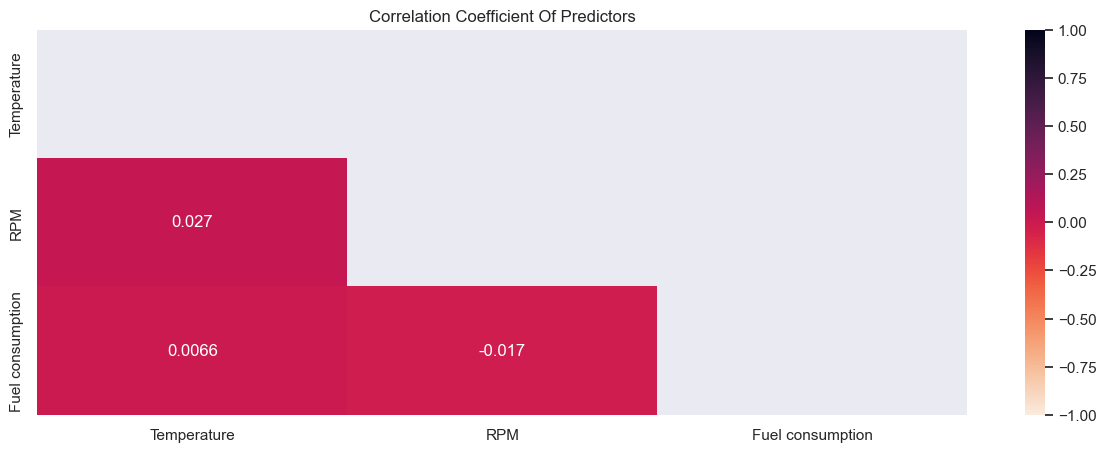

In [532]:
plt.figure(figsize=(15,5))
mask = np.triu(np.ones_like(df[["Temperature","RPM","Fuel consumption"]].corr(), dtype=bool))

# generate heatmap
sns.heatmap(df[["Temperature","RPM","Fuel consumption"]].corr(), annot=True, mask=mask, vmin=-1, vmax=1, cmap=sns.cm.rocket_r)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

Based on the heatmap above, we noted that while most numeric independent variables do not exhibit strong relationship with each other. Therefore, we will choose not to drop any variable as they may constitute information that may be useful for model training to ensure robustness.


## 3.9.2 Implementing Chi-Square between categorical data


We'll first start off by segregating each categorical variable from the other categorical variables to perform chi-square testing for each variable against the rest.


In [533]:
x_model = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_model = df["model_encoded"]
chi_scores_model = chi2(x_model,y_model)

x_year = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_year = df["year_encoded"]
chi_scores_year = chi2(x_year,y_year)

x_usage = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_usage = df["usage_encoded"]
chi_scores_usage = chi2(x_usage,y_usage)

x_membership = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_membership = df["membership_encoded"]
chi_scores_membership = chi2(x_membership,y_membership)

x_factory_china = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_factory_china = df["factory_china_encoded"]
chi_scores_factory_china = chi2(x_factory_china,y_factory_china)

x_factory_germany = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_factory_germany = df["factory_germany_encoded"]
chi_scores_factory_germany = chi2(x_factory_germany,y_factory_germany)

x_factory_us = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_factory_us = df["factory_us_encoded"]
chi_scores_factory_us = chi2(x_factory_us,y_factory_us)

Next, we'll obtain the p-values for each categorical variable against the rest of the categorical variables to be combined into a dataset, where it'll be visualised and analysed.


In [534]:
p_values_model = pd.Series(chi_scores_model[1],index = x_model.columns)
p_values_model.sort_values(ascending = False , inplace = True)

p_values_year = pd.Series(chi_scores_year[1],index = x_year.columns)
p_values_year.sort_values(ascending = False , inplace = True)

p_values_usage = pd.Series(chi_scores_usage[1],index = x_usage.columns)
p_values_usage.sort_values(ascending = False , inplace = True)

p_values_membership = pd.Series(chi_scores_membership[1],index = x_membership.columns)
p_values_membership.sort_values(ascending = False , inplace = True)

p_values_factory_china = pd.Series(chi_scores_factory_china[1],index = x_factory_china.columns)
p_values_factory_china.sort_values(ascending = False , inplace = True)

p_values_factory_germany = pd.Series(chi_scores_factory_germany[1],index = x_factory_germany.columns)
p_values_factory_germany.sort_values(ascending = False , inplace = True)

p_values_factory_us = pd.Series(chi_scores_factory_us[1],index = x_factory_us.columns)
p_values_factory_us.sort_values(ascending = False , inplace = True)

In [535]:
chi2_df = pd.concat([p_values_membership,p_values_factory_china,p_values_factory_us,p_values_usage,p_values_year,p_values_factory_germany,p_values_model], axis=1)
chi2_df.columns = ["membership_encoded","factory_china_encoded","factory_us_encoded","usage_encoded","year_encoded","factory_germany_encoded","model_encoded"]

In [536]:
chi2_df.sort_index(inplace=True)
chi2_df = chi2_df.sort_index(axis = 1)

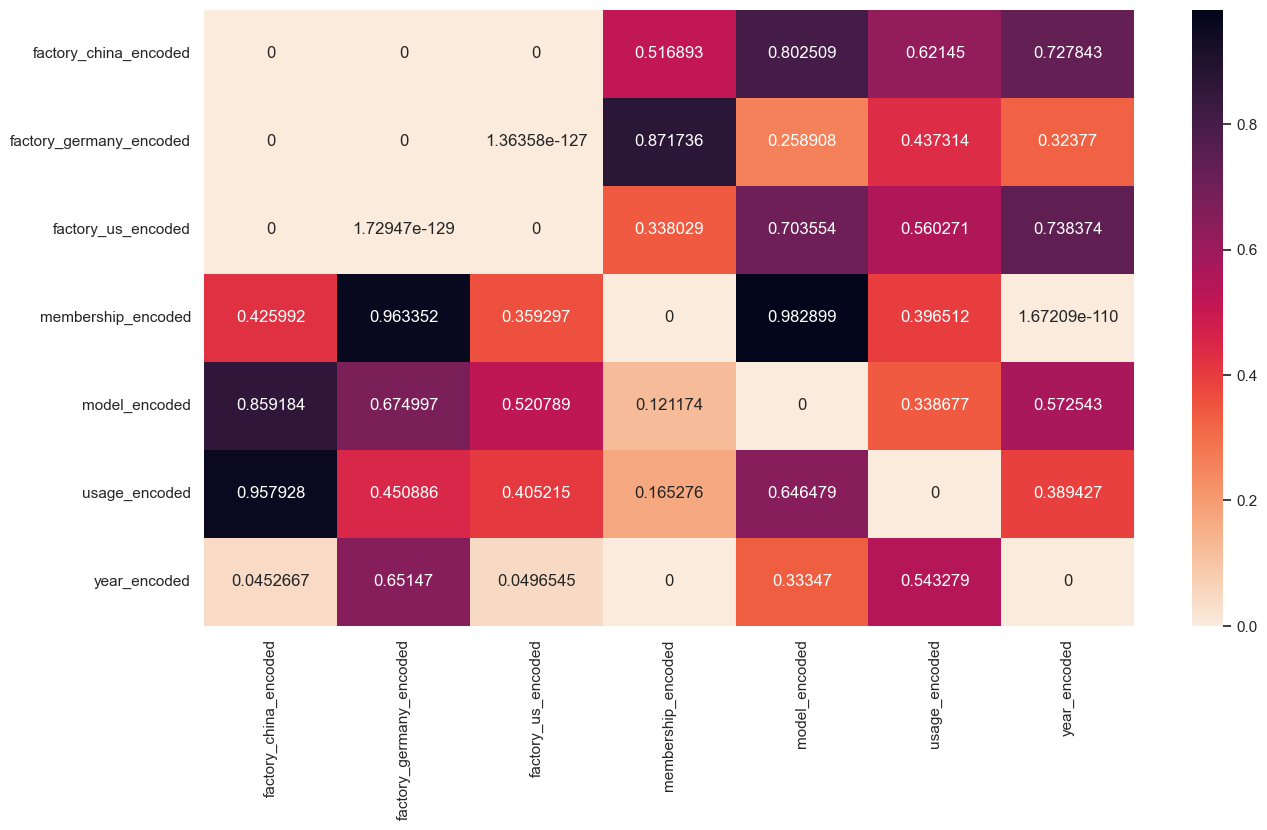

In [537]:
figsize = (15, 8)
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(chi2_df, annot=True, fmt="g", cmap=sns.cm.rocket_r)
plt.show()

With the significance level set at 5%, the following are the interpretation of the p value:

1. p < 0.05 — this means the two categorical variables are correlated.
2. p > 0.05 — this means the two categorical variables are not correlated.

Based on the above, the following variables are correlated:

1. membership_encoded vs year_encoded
2. factory_us_encoded vs factory_germany_encoded
3. factory_china_encoded vs year_encoded
4. factory_us_encoded vd year_encoded

However, we will not be dropping these variables yet as we will continue to analyse the correlation between each independent variable against the dependent variable for final feature selection.


# 4.0 Analysing Independent Variable - Dependent Variable correlation for final feature selection

In this section we will assess if there are independent variables that are not highly correlated with the dependent variable. If there are independent variables that do not correlate highly with the dependent variable, it could possibly not have strong predicting power to predict the dependent variable y.

Therefore, in this case, we will be using the following metric to determine correlation between the independent variables against the dependent variable:

1. Chi-Square between categorical independent variables and the dependent variable


## 4.1 Implementing Chi-Square between categorical independent variables and the dependent variable


In [538]:
x_variables = df[["model_encoded","year_encoded","usage_encoded","membership_encoded","factory_china_encoded","factory_germany_encoded","factory_us_encoded"]]
y_variable = df["y"]
chi_scores_target = chi2(x_variables,y_variable)

In [539]:
p_values_target = pd.Series(chi_scores_target[1],index = x_variables.columns)
p_values_target.sort_values(ascending = False , inplace = True)

In [540]:
p_values_target.column = ["y"]
p_values_target

factory_germany_encoded     6.898484e-01
factory_china_encoded       3.572988e-01
factory_us_encoded          5.744595e-02
model_encoded               2.878334e-02
usage_encoded               3.403637e-21
membership_encoded          3.108741e-35
year_encoded               2.957864e-102
dtype: float64

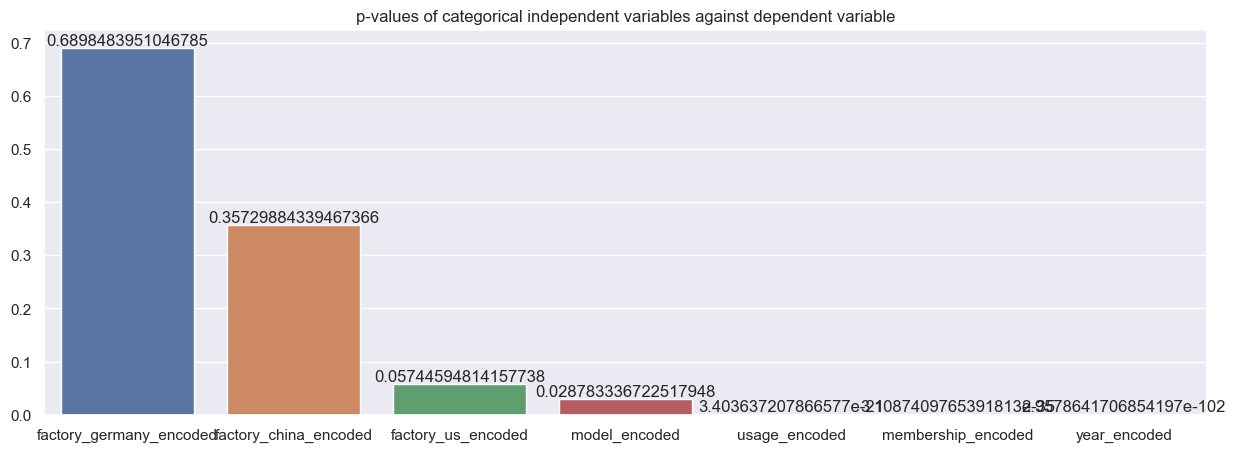

In [541]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(x=p_values_target.index, y=p_values_target)
abs_values = p_values_target.values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('p-values of categorical independent variables against dependent variable')
plt.show()

With the significance level set at 5%, the following are the interpretation of the p value:

1. p < 0.05 — this means the two categorical variables are correlated.
2. p > 0.05 — this means the two categorical variables are not correlated.

Based on the above, the following variables are not highly correlated with the target dependent variable:

1. factory_germany_encoded


## 4.2 Dropping IVs that were highly correlated with each other and that were not highly correlated with the target variable

These variables are:  
**1. year_encoded**  
**2. factory_germany_encoded**

By dropping the 'year_encoded' variable, we will no longer need to drop the other correlated independent variables such as "membership_encoded", "factory_us_encoded" and "factory_china_encoded" as identified in the earlier section.

Additionally, by dropping the "factory_germany_encoded" variable, we will no longer need to drop the other correlated independent variable - "factory_us_encoded" as identified in the earlier section.

We will proceed to drop these variables in the next section as we split the data into train/test split.


# 5.0 Train/test split

Having completed the initial pre-processing of the data, we are now ready to apply further data processing techniques and to train and evaluate models to predict the occurrence of car failure for the automotive company to formulate mitigative policies.

First, we'll first need to subset the data, to ignore variables that we will not be keeping. Thereafter, we will split our dataset into training and test data.


In [542]:
df.columns

Index(['Car ID', 'Model', 'Year', 'Temperature', 'RPM', 'Factory', 'Usage',
       'Fuel consumption', 'Membership', 'Failure A', 'Failure B', 'Failure C',
       'Failure D', 'Failure E', 'y', 'model_encoded', 'year_encoded',
       'usage_encoded', 'membership_encoded', 'factory_china_encoded',
       'factory_germany_encoded', 'factory_us_encoded'],
      dtype='object')

In [543]:
cols = df.columns.tolist()

In [544]:
new_cols = cols[3:5]+cols[7:8]+cols[15:16]+cols[17:20]+cols[21:]+cols[14:15]
new_cols

['Temperature',
 'RPM',
 'Fuel consumption',
 'model_encoded',
 'usage_encoded',
 'membership_encoded',
 'factory_china_encoded',
 'factory_us_encoded',
 'y']

In [545]:
df = df[new_cols]
df.head(1)

,Temperature,RPM,Fuel consumption,model_encoded,usage_encoded,membership_encoded,factory_china_encoded,factory_us_encoded,y
0,110.3,7.346655,6.491785,1,1,1,1.0,0.0,0


**_Further splitting data into x and y variables_**


In [132]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2023, stratify=y)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [134]:
print("The X_train dataset has", len(X_train), "rows.")
print("The X_test dataset has", len(X_test), "rows.")
print("The y_train dataset has", len(y_train), "rows.")
print("The y_test dataset has", len(y_test), "rows.")

The X_train dataset has 6302 rows.
The X_test dataset has 3104 rows.
The y_train dataset has 6302 rows.
The y_test dataset has 3104 rows.


# 6.0 Checking for data imbalance


Next, we will need to check if the data is imbalanced, where one or more classes make up a large proportion of the data set. To do this, we'll plot a bar chart showing the count of value 0, which refers to no occurrence of car failure, and value 1, which refers to occurrence of car failure.


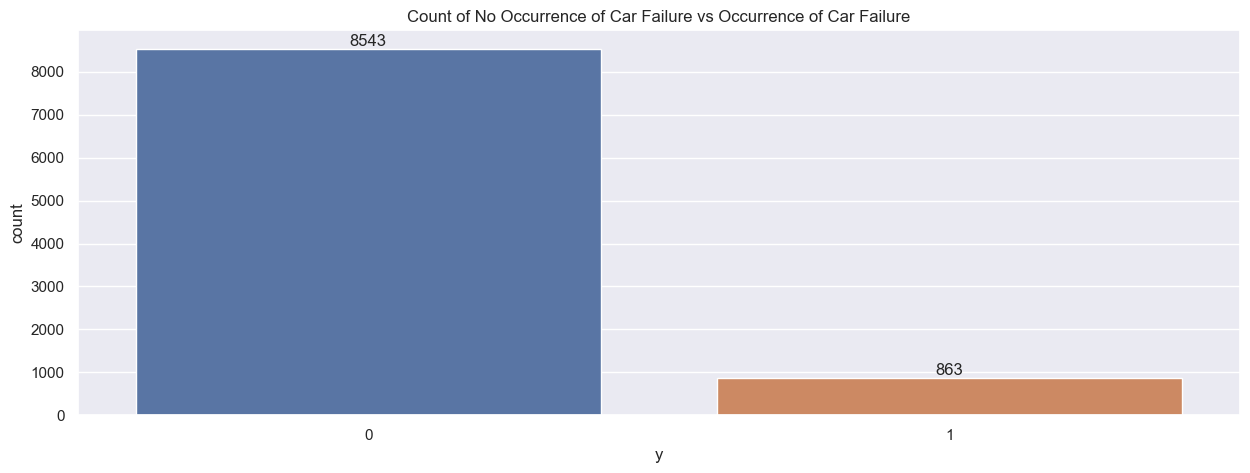

In [135]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x=df["y"], order=df['y'].value_counts().index)
abs_values = df['y'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Count of No Occurrence of Car Failure vs Occurrence of Car Failure')
plt.show()

Based on the bar chart above, we can see that the data is imbalanced, where the target variable with no car failures have a total of 8,543 data points, which accounts for...


In [136]:
df[df["y"]==0]["y"].count() / df["y"].count()

0.908250053157559

... approximately 90.8% of the entire population.

Therefore, we will need to apply random resampling of the data, which involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.

In the next section, we will be experimenting with various random oversampling and undersampling prior to training our model.


# 7.0 Building Pipeline for Further Data Processing and Model Comparison


**Data Scaling**  
It is a common requirement for multiple machine learning algorithms to have standardised dataset as an input as several learning algorithm assumes that features are centered around 0 and have variance in the same order.
Therefore, we will implement standardisation across the independent variables.

In this case, we will be experimenting with using standard scaling and min-max scaling.

**Random Resampling**  
When dealing with imbalanced data, we can resample the training data to reduce the class imbalance to ensure overfitting from occurring when the model is unable to generalised across newly input data as it learns from the majority class. Methods of resampling includes undersampling the majority class, oversampling the minority class, or a combination of both.

In this case, we will be experimenting with sklearn's RandomOverSampler to oversample the minority class (1 - Occurrence of Car Failure) and RandomUnderSampler to undersample the majority class (0 - No Occurrence of Car Failure), as well as SMOTE, which also oversamples the minority class.

**Cross-validation**  
Prior to training the model, we will be employing cross-validation techniques to cross-validate our models' performances.

There are several cross-validation techniques that can be employed as discussed below:

KFold aims to train our models on subsets of the input data (k-1) and evaluating them on the complementary subset of the data. The dataset is split into k consecutive folds. Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In Stratified KFold, the folds are made by preserving the percentage of samples for each class. This is particularly useful in cases where there are class imbalance.

A Repeated Stratified KFold in turn repeats Stratified K-Fold n times with different randomization in each repetition, producing different splits in each repetition.

**Machine Learning Algorithms**  
We will be experimenting with four algorithms that can be used for binary classification problems. The four algorithms are as follow:

<u>Logistic Regression</u>  
In two-class classification, the weighted logistic regression can be an advantage in a binary classification problem with imbalanced data because it allows for adjusting the weight of each class, in order to give more importance to the minority class. This can help to balance the class distribution and improve the overall performance of the model by reducing the bias towards the majority class.

<u>KNeighbors Classifier (KNN)</u>  
The k-NN algorithm is a distance-based algorithm that assumes similar datapoints exist in close proximity. It can be beneficial in a binary classification problem with imbalanced data because it allows for adjusting the number of nearest neighbors considered (k) in the decision-making process. By increasing the value of k, the decision boundary of the model can be made more inclusive, which can help to increase the representation of the minority class and reduce the bias towards the majority class. Additionally, k-NN is a non-parametric algorithm, which means it does not make assumptions about the underlying distribution of the data, which can be useful when the data is imbalanced.

<u>Random Forest Classifier</u>  
The Random Forest Classifier can be beneficial in a binary classification problem with imbalanced data because it uses an ensemble of decision trees, which can help to reduce the bias towards the majority class. It creates multiple decision trees during the training process, and the final output is determined by the majority vote of the individual trees. Because it uses multiple decision trees, it can help to reduce overfitting, which is a common problem when working with imbalanced data. Additionally, Random Forest classifier can handle high dimensional feature space and can be used to identify the feature importance, which can be useful when working with imbalanced data.

<u>Gradient Boosting Classifier</u>  
Gradient Boosting classifier can be beneficial in a binary classification problem with imbalanced data because it is an ensemble method that can help to reduce the bias towards the majority class. It creates multiple decision trees during the training process, but unlike the random forest classifier, it focuses on the misclassified data points from previous decision tree. By iteratively training decision trees on the misclassified data points, it can help to improve the overall performance of the model and reduce bias towards the majority class.


## 7.1 Methodology for Building Pipeline

**_Workflow_**  
We will be building a pipeline to pipe the data through an iteration of resampling techniques, scaling techniques, cross-validation techniques before feeding the data into various model algorithms to determine the best data processing techniques and algorithm based on the iteration with the best performing evaluation metrics.


In [225]:
# define pipeline
resamplers = [RandomUnderSampler(random_state=2023), RandomOverSampler(random_state=2023), SMOTE(random_state=2023)]

scalers =  [StandardScaler(), MinMaxScaler()]

crossvals = [RepeatedStratifiedKFold(random_state=2023), StratifiedKFold(shuffle=True, random_state=2023), KFold(shuffle=True, random_state=2023)]

models = [LogisticRegression(random_state=2023), 
          KNeighborsClassifier(), 
          RandomForestClassifier(random_state=2023),
          GradientBoostingClassifier(random_state=2023)
         ]

compiled_results = []

for resampler in resamplers:
    for scaler in scalers:
        for crossval in crossvals:
            for model in models:
                print(resampler)
                print(scaler)
                print(crossval)
                print(model)
                steps = [('scaler', scaler), ('resample', resampler), ('model', model)]
                pipeline = Pipeline(steps=steps)
                cv = crossval

                scoring_types=['accuracy','precision','recall','f1']

                scoring_results = []
                for scoring_type in scoring_types:
                    scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring_type, cv=cv, n_jobs=-1)
                    score = np.mean(scores)
                    scoring_results.append(score)
                    print(scoring_type, 'Score: %.3f' % score)
                print("")
                compiled_results.append([resampler, scaler, crossval, model, scoring_results])

RandomUnderSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
LogisticRegression(random_state=2023)
accuracy Score: 0.679
precision Score: 0.175
recall Score: 0.677
f1 Score: 0.279

RandomUnderSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.703


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.179


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.623


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.278

RandomUnderSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.743
precision Score: 0.215
recall Score: 0.677
f1 Score: 0.326

RandomUnderSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.778
precision Score: 0.246
recall Score: 0.686
f1 Score: 0.362

RandomUnderSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.677
precision Score: 0.174
recall Score: 0.675
f1 Score: 0.277

RandomUnderSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()
accuracy Score: 0.703


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.178
recall Score: 0.616
f1 Score: 0.276

RandomUnderSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.742
precision Score: 0.215
recall Score: 0.687
f1 Score: 0.328

RandomUnderSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.773
precision Score: 0.240
recall Score: 0.683
f1 Score: 0.355

RandomUnderSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.678
precision Score: 0.178
recall Score: 0.691
f1 Score: 0.282

RandomUnderSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()
accuracy Score: 0.692


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.170
recall Score: 0.610
f1 Score: 0.266

RandomUnderSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.743
precision Score: 0.217
recall Score: 0.688
f1 Score: 0.329

RandomUnderSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.780
precision Score: 0.250
recall Score: 0.700
f1 Score: 0.368

RandomUnderSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
LogisticRegression(random_state=2023)
accuracy Score: 0.675
precision Score: 0.173
recall Score: 0.671
f1 Score: 0.275

RandomUnderSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.708


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.179


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.607


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.276

RandomUnderSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.743
precision Score: 0.215
recall Score: 0.678
f1 Score: 0.326

RandomUnderSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.778
precision Score: 0.246
recall Score: 0.686
f1 Score: 0.362

RandomUnderSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.674
precision Score: 0.171
recall Score: 0.664
f1 Score: 0.272

RandomUnderSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()
accuracy Score: 0.716


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.182
recall Score: 0.600
f1 Score: 0.279

RandomUnderSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.743
precision Score: 0.216
recall Score: 0.687
f1 Score: 0.329

RandomUnderSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.773
precision Score: 0.240
recall Score: 0.683
f1 Score: 0.355

RandomUnderSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.673
precision Score: 0.173
recall Score: 0.677
f1 Score: 0.275

RandomUnderSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()
accuracy Score: 0.696


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.171
recall Score: 0.599
f1 Score: 0.266

RandomUnderSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.744
precision Score: 0.218
recall Score: 0.690
f1 Score: 0.331

RandomUnderSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.780
precision Score: 0.250
recall Score: 0.700
f1 Score: 0.368

RandomOverSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
LogisticRegression(random_state=2023)
accuracy Score: 0.679
precision Score: 0.176
recall Score: 0.676
f1 Score: 0.279

RandomOverSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.790


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.197


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.421


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.269

RandomOverSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.912
precision Score: 0.537
recall Score: 0.282
f1 Score: 0.368

RandomOverSampler(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.828
precision Score: 0.298
recall Score: 0.644
f1 Score: 0.408

RandomOverSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.681
precision Score: 0.176
recall Score: 0.671
f1 Score: 0.278

RandomOverSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.788
precision Score: 0.195


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.420
f1 Score: 0.266

RandomOverSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.912
precision Score: 0.540
recall Score: 0.280
f1 Score: 0.368

RandomOverSampler(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.832
precision Score: 0.305
recall Score: 0.642
f1 Score: 0.413

RandomOverSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.679
precision Score: 0.175
recall Score: 0.671
f1 Score: 0.277

RandomOverSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.787
precision Score: 0.192


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.413
f1 Score: 0.262

RandomOverSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.910
precision Score: 0.518
recall Score: 0.278
f1 Score: 0.359

RandomOverSampler(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.830
precision Score: 0.301
recall Score: 0.649
f1 Score: 0.411

RandomOverSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
LogisticRegression(random_state=2023)
accuracy Score: 0.679
precision Score: 0.175
recall Score: 0.675
f1 Score: 0.278

RandomOverSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.792


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.203


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.432


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.276

RandomOverSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.912
precision Score: 0.538
recall Score: 0.281
f1 Score: 0.368

RandomOverSampler(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.828
precision Score: 0.298
recall Score: 0.644
f1 Score: 0.408

RandomOverSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.681
precision Score: 0.174
recall Score: 0.664
f1 Score: 0.276

RandomOverSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.792
precision Score: 0.200
recall Score: 0.425


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.272

RandomOverSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.912
precision Score: 0.544
recall Score: 0.280
f1 Score: 0.369

RandomOverSampler(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.832
precision Score: 0.305
recall Score: 0.642
f1 Score: 0.413

RandomOverSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.678
precision Score: 0.174
recall Score: 0.669
f1 Score: 0.276

RandomOverSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.795
precision Score: 0.205


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.426
f1 Score: 0.276

RandomOverSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.910
precision Score: 0.519
recall Score: 0.278
f1 Score: 0.360

RandomOverSampler(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.830
precision Score: 0.301
recall Score: 0.649
f1 Score: 0.411

SMOTE(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
LogisticRegression(random_state=2023)
accuracy Score: 0.689
precision Score: 0.180
recall Score: 0.671
f1 Score: 0.284

SMOTE(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.770


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.190


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.463


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.269

SMOTE(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.870
precision Score: 0.333
recall Score: 0.415
f1 Score: 0.369

SMOTE(random_state=2023)
StandardScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.856
precision Score: 0.337
recall Score: 0.583
f1 Score: 0.426

SMOTE(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.690
precision Score: 0.180
recall Score: 0.673
f1 Score: 0.285

SMOTE(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.770
precision Score: 0.190


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.465
f1 Score: 0.270

SMOTE(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.868
precision Score: 0.330
recall Score: 0.415
f1 Score: 0.366

SMOTE(random_state=2023)
StandardScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.854
precision Score: 0.333
recall Score: 0.583
f1 Score: 0.423

SMOTE(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.688
precision Score: 0.179
recall Score: 0.668
f1 Score: 0.282

SMOTE(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.769
precision Score: 0.193


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.475
f1 Score: 0.274

SMOTE(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.874
precision Score: 0.352
recall Score: 0.438
f1 Score: 0.390

SMOTE(random_state=2023)
StandardScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.858
precision Score: 0.341
recall Score: 0.581
f1 Score: 0.429

SMOTE(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
LogisticRegression(random_state=2023)
accuracy Score: 0.688
precision Score: 0.179
recall Score: 0.670
f1 Score: 0.282

SMOTE(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.757


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.183


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.476


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.264

SMOTE(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.849
precision Score: 0.292
recall Score: 0.451
f1 Score: 0.354

SMOTE(random_state=2023)
MinMaxScaler()
RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2023)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.833
precision Score: 0.298
recall Score: 0.607
f1 Score: 0.400

SMOTE(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.689
precision Score: 0.180
recall Score: 0.673
f1 Score: 0.284

SMOTE(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.757
precision Score: 0.179
recall Score: 0.463


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.258

SMOTE(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.847
precision Score: 0.285
recall Score: 0.441
f1 Score: 0.346

SMOTE(random_state=2023)
MinMaxScaler()
StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.830
precision Score: 0.296
recall Score: 0.614
f1 Score: 0.399

SMOTE(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
LogisticRegression(random_state=2023)
accuracy Score: 0.684
precision Score: 0.177
recall Score: 0.670
f1 Score: 0.280

SMOTE(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
KNeighborsClassifier()
accuracy Score: 0.760


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.187
recall Score: 0.478


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.268

SMOTE(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
RandomForestClassifier(random_state=2023)
accuracy Score: 0.852
precision Score: 0.299
recall Score: 0.456
f1 Score: 0.360

SMOTE(random_state=2023)
MinMaxScaler()
KFold(n_splits=5, random_state=2023, shuffle=True)
GradientBoostingClassifier(random_state=2023)
accuracy Score: 0.833
precision Score: 0.299
recall Score: 0.610
f1 Score: 0.401



**_Structuring results into a dataframe for easier comparison_**


In [226]:
results = pd.DataFrame(compiled_results, columns=['resampler','scaler','crossval','model','score'])

**_Separating list of scores into individual columns_**


In [227]:
results[['acc','pre','re','f1']] = pd.DataFrame(results.score.tolist(), index= results.index)

**_Determining the best perfoming data processing techniques and algorithm based on best performing evaluation metric_**

Based on the results compiled, we will now evaluate the performance of the best iteration by reviewing the following metrics, and the reason for reviewing these metrics:

1. Accuracy Score
2. Precision Score
3. Recall Score
4. F1 Score

##### Accuracy Score

We are interested in evaluating how correct our classifier is in classifying the failure type.

##### Recall Score

It is also important that we do not wrongly predict an occurrence of a car failure type as a non-failure. As an automotive insurance company, it would be costly to have to payout to a claim for car failure when it was predicted to be a non-failure.

##### Precision Score

However, we are also interested in how precise we are in predicting car failures, as any false prediction of a non-failure as a failure would mean that it would result in a higher premium paid by the customer for their automotive insurance, assuming that with a higher risk of car failure, the insurance company would charge the customer more.

With too high a premium, it might cause customer to churn or be less attractive to new potential customers.

##### F1 Score

Therefore, with the assumption that Precision Score is as important as the Recall Score, we want to evaluate our classifer by measuring the F1 Score. F1 Score is calculated by obtaining the harmonic mean of both Recall Score and Precision Score.


In this case, we will be evaluating, which model performed best, based on the models trained above, by taking the max of accuracy, precision, recall and f1 scores.


**_Model with best accuracy score_**


In [228]:
results[results['acc']==results['acc'].max()]

,resampler,scaler,crossval,model,score,acc,pre,re,f1
42,RandomOverSampler(random_state=2023),MinMaxScaler(),"StratifiedKFold(n_splits=5, random_state=2023,...",RandomForestClassifier(random_state=2023),"[0.9124088969449794, 0.5443096203998842, 0.280...",0.912409,0.54431,0.280165,0.368584


**_Model with best precision score_**


In [229]:
results[results['pre']==results['pre'].max()]

,resampler,scaler,crossval,model,score,acc,pre,re,f1
42,RandomOverSampler(random_state=2023),MinMaxScaler(),"StratifiedKFold(n_splits=5, random_state=2023,...",RandomForestClassifier(random_state=2023),"[0.9124088969449794, 0.5443096203998842, 0.280...",0.912409,0.54431,0.280165,0.368584


**_Model with best recall score_**


In [230]:
results[results['re']==results['re'].max()]

,resampler,scaler,crossval,model,score,acc,pre,re,f1
11,RandomUnderSampler(random_state=2023),StandardScaler(),"KFold(n_splits=5, random_state=2023, shuffle=T...",GradientBoostingClassifier(random_state=2023),"[0.7795927897989753, 0.2500439887714551, 0.700...",0.779593,0.250044,0.700006,0.36782
23,RandomUnderSampler(random_state=2023),MinMaxScaler(),"KFold(n_splits=5, random_state=2023, shuffle=T...",GradientBoostingClassifier(random_state=2023),"[0.7795927897989753, 0.2500439887714551, 0.700...",0.779593,0.250044,0.700006,0.36782


**_Model with best f1 score_**


In [231]:
results[results['f1']==results['f1'].max()]

,resampler,scaler,crossval,model,score,acc,pre,re,f1
59,SMOTE(random_state=2023),StandardScaler(),"KFold(n_splits=5, random_state=2023, shuffle=T...",GradientBoostingClassifier(random_state=2023),"[0.8581394207167403, 0.3414820399364727, 0.580...",0.858139,0.341482,0.580799,0.429256


## 7.2 Model Evaluation

The following provides a summary of the results obtained above:

**Best Accuracy Score - 0.9124**

1. Random oversample
2. MinMax Scale
3. Stratified KFold
4. Random Forest Classifier

**Best Precision Score - 0.5443**

1. Random oversample
2. MinMax Scale
3. Stratified KFold
4. Random Forest Classifier

**Best Recall Score - 0.7000**

1. Random undersample
2. Standard Scale & MinMax Scale
3. KFold
4. Gradient Boosting Classifier

**Best F1 Score - 0.4293**

1. SMOTE
2. Standard Scale
3. KFold
4. Gradient Boosting Classifier


### 7.2.1 Validating Chosen Model

While accuracy score is important, we also need to take into consideration of other evaluation metrics such as precision and recall. As mentioned above, with a low precision score, any false prediction of a non-failure as a failure would mean that it would result in a higher premium paid by the customer for their automotive insurance. On the other hand, having a low recall score would mean that it would be costly for the automotive insurance company to have to make a payout to a claim for car failure when it was predicted to be a non-failure.

Therefore, we will be interested in training a model that is able to account and balance out both precision and recall. In this case, the model with the best F1 score is a **gradient boosting classifier** that uses SMOTE for oversampling, standard scaling and Kfold for cross-validation.

**In the next section, we will evaluate how well the model performs on the test split dataset.**


In [232]:
# define pipeline
resampler = SMOTE(random_state=2023)

scaler =  StandardScaler()

crossval = KFold(shuffle=True, random_state=2023)

model = GradientBoostingClassifier(random_state=2023)

steps = [('scaler', scaler), ('resampler', resampler), ('model', model)]

pipeline = Pipeline(steps=steps)
cv = crossval

scoring_types=['accuracy','precision','recall','f1']

scoring_results = []
for scoring_type in scoring_types:
    scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring_type, cv=cv, n_jobs=-1)
    score = np.mean(scores)
    scoring_results.append(score)
    print(scoring_type, 'Score: %.3f' % score)
    
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat)
print(classification_report(y_test, y_hat))
conf_mat

accuracy Score: 0.858
precision Score: 0.341
recall Score: 0.581
f1 Score: 0.429
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2819
           1       0.35      0.62      0.45       285

    accuracy                           0.86      3104
   macro avg       0.66      0.75      0.68      3104
weighted avg       0.90      0.86      0.88      3104



array([[2491,  328],
       [ 107,  178]])

**Based on the above, we can see that the model seems to generalise well over an unseen test data set**


**Discussion on benefits of the selected data processing methodology, and the benefits of the chosen model - Gradient Boosting Classifier**

<u>SMOTE</u>  
Instead of replicating the existing data points, SMOTE creates more samples in the minority class by creating new points within the range of possibility. This differs from oversampling, which duplicates existing samples in the minority class. Therefore, SMOTE allows for the model to be more robust by training on a balanced dataset that has more information.

<u>Standard Scaling</u>  
With Standard scaling, the feature columns are centered at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distribution. While a tree-based algorithm does not require feature scaling as it is not sensitive to the variance in the data, it makes it easier for most machine learning algorithms to learn the weights. Standardisation also helps to maintain useful information about outliers and makes the algorithm less sensitive to them.

<u>KFold</u>  
KFold cross-validation helps to ensure that the model is built to be more generalized to prevent overfitting. This is especially useful in this case where the data is imbalance. Kfold cross-validation helps to preserve the imbalanced class distribution in each fold.

<u>Gradient Boosting Classifier</u>  
Gradient Boosting classifier can be beneficial in a binary classification problem with imbalanced data because it is an ensemble method that can help to reduce the bias towards the majority class. It creates multiple decision trees during the training process, but unlike the random forest classifier, it focuses on the misclassified data points from previous decision tree. By iteratively training decision trees on the misclassified data points, it can help to improve the overall performance of the model and reduce bias towards the majority class.


### 7.2.2 Experimenting with Other Models

While we have identified that the Gradient Boosting Classifier is the best performing model without optimizing any parameters, we would also like to experiment how setting hyperparameters for other models could help it to achieve better results.

For example, logistic regression allows for the assigning of class weights. This could prove useful when working with an imbalanced dataset.


**_Weighted Logistic Regression_**


In [319]:
# define pipeline
resampler = SMOTE(random_state=2023)

scaler =  StandardScaler()

crossval = KFold(shuffle=True, random_state=2023)

model_1 = LogisticRegression(random_state=2023)
model_2 = LogisticRegression(class_weight={0:75, 1: 32}, random_state=2023)

models = [model_1, model_2]

for model in models:
    print("\n","Model:", model)
    steps = [('scaler', scaler), ('resampler', resampler), ('model', model)]

    lr_pipeline = Pipeline(steps=steps)
    cv = crossval

    scoring_types=['accuracy','precision','recall','f1']

    scoring_results = []
    for scoring_type in scoring_types:
        scores = cross_val_score(lr_pipeline, X_train, y_train, scoring=scoring_type, cv=cv, n_jobs=-1)
        score = np.mean(scores)
        scoring_results.append(score)
        print(scoring_type, 'Score: %.3f' % score)

    lr_pipeline.fit(X_train, y_train)
    y_hat = lr_pipeline.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat)
    print(classification_report(y_test, y_hat))
    print(conf_mat)


 Model: LogisticRegression(random_state=2023)
accuracy Score: 0.688
precision Score: 0.179
recall Score: 0.668
f1 Score: 0.282
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      2819
           1       0.18      0.68      0.29       285

    accuracy                           0.69      3104
   macro avg       0.57      0.69      0.55      3104
weighted avg       0.88      0.69      0.76      3104

[[1964  855]
 [  92  193]]

 Model: LogisticRegression(class_weight={0: 75, 1: 32}, random_state=2023)
accuracy Score: 0.869
precision Score: 0.314
recall Score: 0.362
f1 Score: 0.336
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2819
           1       0.34      0.39      0.36       285

    accuracy                           0.87      3104
   macro avg       0.64      0.66      0.65      3104
weighted avg       0.88      0.87      0.88      3104

[[2601  218]
 [ 173  112]]


As seen above, when we allow for the setting of class weights, it would allow the model to give more importance to the class with higher weights.


**_KNeighborsClassifier_**


In [322]:
# define pipeline
resampler = SMOTE(random_state=2023)

scaler =  StandardScaler()

crossval = KFold(shuffle=True, random_state=2023)

model_1 = KNeighborsClassifier()
model_2 = KNeighborsClassifier(n_neighbors=10)

models = [model_1, model_2]

for model in models:
    print("\n","Model:", model)
    steps = [('scaler', scaler), ('resampler', resampler), ('model', model)]

    knn_pipeline = Pipeline(steps=steps)
    cv = crossval

    scoring_types=['accuracy','precision','recall','f1']

    scoring_results = []
    for scoring_type in scoring_types:
        scores = cross_val_score(knn_pipeline, X_train, y_train, scoring=scoring_type, cv=cv, n_jobs=-1)
        score = np.mean(scores)
        scoring_results.append(score)
        print(scoring_type, 'Score: %.3f' % score)

    knn_pipeline.fit(X_train, y_train)
    y_hat = knn_pipeline.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat)
    print(classification_report(y_test, y_hat))
    print(conf_mat)


 Model: KNeighborsClassifier()
accuracy Score: 0.769


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

precision Score: 0.193
recall Score: 0.475


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.274
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      2819
           1       0.21      0.50      0.29       285

    accuracy                           0.78      3104
   macro avg       0.57      0.65      0.58      3104
weighted avg       0.87      0.78      0.82      3104

[[2276  543]
 [ 143  142]]

 Model: KNeighborsClassifier(n_neighbors=10)


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

accuracy Score: 0.757
precision Score: 0.194


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

recall Score: 0.521


/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/samuel/opt/anaconda3/envs/aisgenv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

f1 Score: 0.282
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      2819
           1       0.21      0.54      0.31       285

    accuracy                           0.78      3104
   macro avg       0.58      0.67      0.59      3104
weighted avg       0.88      0.78      0.82      3104

[[2256  563]
 [ 132  153]]


Based on the above, we can see that as we increase the number of k neighbours, the performance of the model increases.

With k = 5, the model's validation f1 score is 0.29. With k = 10, the model's validation f1 score is 0.31.

By increasing the value of k, the decision boundary of the model can be made more inclusive, which can help to increase the representation of the minority class and reduce the bias towards the majority class.


**_Random Forest Classifier_**


In [323]:
# define pipeline
resampler = SMOTE(random_state=2023)

scaler =  StandardScaler()

crossval = KFold(shuffle=True, random_state=2023)

model = RandomForestClassifier()


print("\n","Model:", model)
steps = [('scaler', scaler), ('resampler', resampler), ('model', model)]

rfc_pipeline = Pipeline(steps=steps)
cv = crossval

scoring_types=['accuracy','precision','recall','f1']

scoring_results = []
for scoring_type in scoring_types:
    scores = cross_val_score(rfc_pipeline, X_train, y_train, scoring=scoring_type, cv=cv, n_jobs=-1)
    score = np.mean(scores)
    scoring_results.append(score)
    print(scoring_type, 'Score: %.3f' % score)

rfc_pipeline.fit(X_train, y_train)
y_hat = rfc_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat)
print(classification_report(y_test, y_hat))
print(conf_mat)


 Model: RandomForestClassifier()
accuracy Score: 0.873
precision Score: 0.343
recall Score: 0.424
f1 Score: 0.384
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2819
           1       0.35      0.44      0.39       285

    accuracy                           0.87      3104
   macro avg       0.64      0.68      0.66      3104
weighted avg       0.89      0.87      0.88      3104

[[2585  234]
 [ 160  125]]


The Random Forest Classifier performs much better than both the logistic regression model and the k-NN model in terms of the F1 score. When compared to the Gradient Boosting Classifier, however, it does not perform as well.


# 8.0 Hyperparameter tuning

Next, we will proceed to tune the hyperparameter of the model for better optimization.


In [213]:
# Define an oversampling technique
resampler = SMOTE(random_state=2023)

# Define a Standard Scaler to normalize inputs
scaler =  StandardScaler()

# Define a GBC model
model = GradientBoostingClassifier(random_state=2023)

# Define scoring evaluation metrics
scoring = {"Accuracy": "accuracy", "Precision": "precision", "Recall": "recall", "F1": "f1", }

# Input scaler, oversampling, and model
pipe = Pipeline(steps=[("scaler", scaler), ('resampler',resampler), ("model", model)])

# Defining hyperparameters for tuning
parameters = {
    "model__learning_rate": [0.05],
    "model__max_depth":[5],
    "model__criterion": ["friedman_mse"],
    "model__subsample":[1.0],
    "model__n_estimators":[800],
    "model__min_samples_split": [12],
    "model__min_samples_leaf": [8]
    }

# Passing the pipe and scoring function in the GridSearchCV
clf = GridSearchCV(pipe, parameters, scoring=scoring, verbose=2, refit="F1")

clf.fit(X_train, y_train)

# Converting the clf.cv_results to dataframe
clf_df=pd.DataFrame.from_dict(clf.cv_results_)

# Evaluating performance of model with best params on test data
clf_test_score = clf.score(X_test, y_test)

y_hat = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat)


print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)
print("Test F1 Score =", clf_test_score)
print("Classification report", '\n', classification_report(y_test, y_hat))
print("Confusion matrix", '\n',conf_mat)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END model__criterion=friedman_mse, model__learning_rate=0.05, model__max_depth=5, model__min_samples_leaf=8, model__min_samples_split=12, model__n_estimators=800, model__subsample=1.0; total time=  16.6s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.05, model__max_depth=5, model__min_samples_leaf=8, model__min_samples_split=12, model__n_estimators=800, model__subsample=1.0; total time=  16.5s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.05, model__max_depth=5, model__min_samples_leaf=8, model__min_samples_split=12, model__n_estimators=800, model__subsample=1.0; total time=  16.6s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.05, model__max_depth=5, model__min_samples_leaf=8, model__min_samples_split=12, model__n_estimators=800, model__subsample=1.0; total time=  16.6s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.05, model__max_depth=5, model__min_samples

# 9.0 Feature Importance


**_Obtaining list of most important features based on the best performing model_**


In [340]:
feature_impt_score = list(clf.best_estimator_.named_steps["model"].feature_importances_)

In [352]:
feature_name = X.columns.tolist()

**_Combining list of features into a dataframe for visualization_**


In [360]:
feature_impt_df = pd.concat([pd.Series(feature_name), pd.Series(feature_impt_score)], axis=1)

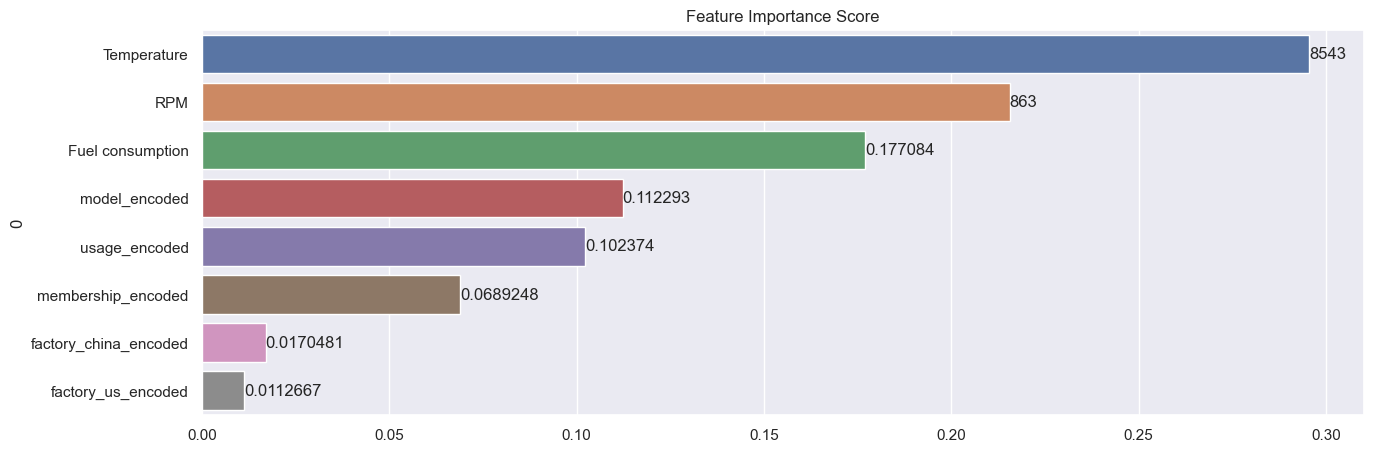

In [391]:
figsize = (15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(x=-np.sort(-feature_impt_df[1]), y=feature_impt_df[0])
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Feature Importance Score')
plt.show()

## 9.1 Visualizing Top 3 Most Important Features


Text(0.5, 1.0, 'Fuel consumption')

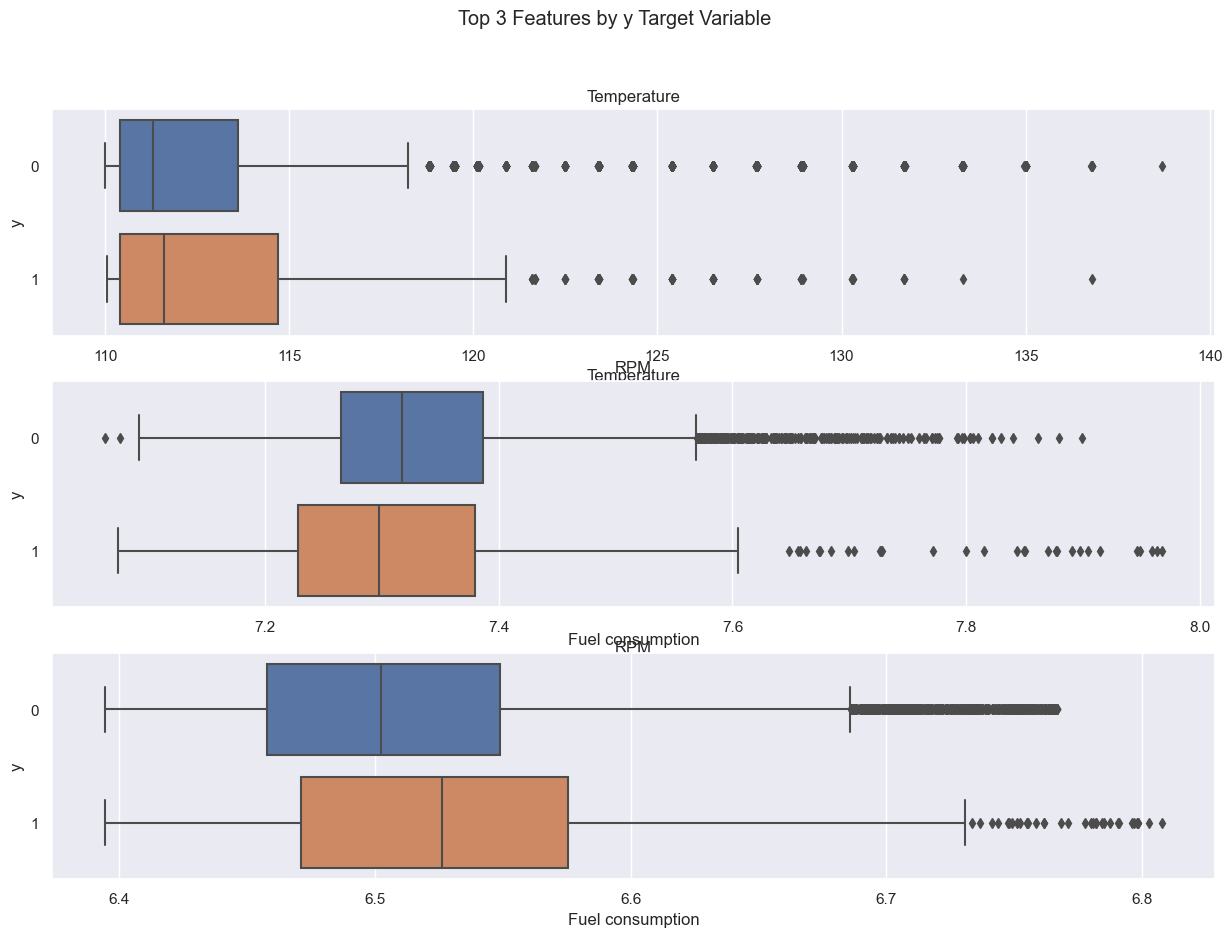

In [546]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=True)
fig.suptitle('Top 3 Features by y Target Variable')

# Temperature vs y
sns.boxplot(ax=axes[0], x=df["Temperature"], y=df["y"].astype(str))
axes[0].set_title("Temperature")

# RPM vs y
sns.boxplot(ax=axes[1], x=df["RPM"], y=df["y"].astype(str))
axes[1].set_title("RPM")

# Fuel consumption vs y
sns.boxplot(ax=axes[2], x=df["Fuel consumption"], y=df["y"].astype(str))
axes[2].set_title("Fuel consumption")

## 9.2 Recommendation for Automative Insurance Company

Based on the side-by-side boxplots above, it seems to indicate that car failures tend to have a higher mean temperature, lower RPM and higher fuel consumption.

Therefore, as an automative insurance company, it would be useful to assign temperature, RPM and fuel consumption as features that would lead to a high impact on car failure.


# 10.0 Future Work

Improvements can still be made to provide for better performance throughout the entire pipeline as delineated below:

1. Data Quality  
   More data can be collected that could provide for more predictive power to the models to be trained. For example, information such as total distance travelled by the car and total number of car maintenance performed on the car since car purchase could be useful in predicting car failures.

2. Data Preprocessing  
   Other oversampling or undersampling methods could be experimented with, such as the Adaptive Synthetic Sampling (ADASYN) technique, which identifies the samples of the minority class that are difficult to classify and then generating synthetic samples that are similar to them. Additionally oversampling can be used in conjunction with undersampling to balance the data.

3. Model Training  
   The current model could still be improved by optimizing the hyperparameters further. Additionally, other algorithms could be experimented with.
